# Student Name: Zhongyue Xing

## Problem 1 (5 points)

Consider the optimal selection of a treatment. Suppose that there are 4 types of treatments available. The outcome of each treatment is either 1 (recovery) or 0.   

Let's denote the outcome by $R_t$, then $R_t|(A_t=a)$ follows $\text{Bernoulli}(p_a)$ with $a\in\{1,2,3,4\}$ and all $p_a\in [0,1]$, where $A_t$ denotes the action on time step $t=1,2,3,\ldots$. 

Assume that $p_1=0.2$, $p_2=0.4$,  $p_3=0.6$, $p_4=0.8$, which are not known to the doctor. This is the 4-armed Bandit Problem with Bernoulli distributions. The rewards $R_t$ are 0's and 1's. Please notice that $P\{R_t=1|A_t=a\}=p_a$. Also, the expectation $E\left[R_t|A_t=a \right]=p_a$.

Develop the Upper-Confidence-Bound Action Selection algorithm for the problem of selecting the best treatment and report the following graphs:   

(a) Run the algorithm for $t=1,2,3,\ldots,1000$ and plot $R_t$'s v.s. $t$ for one simulation. Use $c=0.2$.

(b) Run the trajectory in (a) for 100 epochs; and for each time step $t$ plot the average of $R_t$'s from the epochs at this particular time (please do not average all returns over time - we want to see how the learning progresses over time). Use $c=0.2$.   

(c) Using trajectories you obtained in (b), for each time step $t$, plot the proportion  (out of 100) of times the best action (action $a=4$) was selected by the doctor. Use $c=0.2$.   

(d) Run the algorithm for $c=0,0.1,0.2,0.3,\ldots,4$ (one epoch for each $c$) for $t=1,2,3,\ldots,1000$. Plot proportion of recovery cases (out of first 1000 steps) versus $c$.

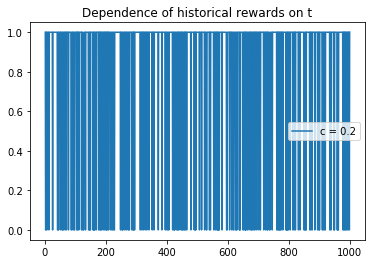

In [2]:
import numpy as np
import random
from collections import defaultdict
from matplotlib import pyplot as plt 


class Environment:
    def __init__(self):
        self.time = 1
        self.best_action = 4

    def admissible_actions(self):
        return list(range(1,5))

    def get_reward(self, action):
        assert action in self.admissible_actions()
        self.time += 1
        p_action = action*0.2
        return np.random.choice([0, 1], p = [1-p_action, p_action])


class Agent:
    def __init__(self, c = 0.2):
        self.c = c
        self.current_reward = None
        self.selected_action = None
        self.t = 0 # number of actions taken
        # Latest action:reward_estimate pairs:
        self.Qk_dict = defaultdict(float)
        # Latest action:reward pairs:
        self.Rk_dict = defaultdict(float)
        # action:k pairs where k is the number of times the action was executed
        self.k_dict = defaultdict(int)

    def estimate_reward(self, action):
        if self.k_dict[action]:
            k = self.k_dict[action]
            Qk = self.Qk_dict[action]
            Rk = self.Rk_dict[action]
            # Return Q_(k+1) by incremental update rule explained in textbook chapter 2.3
            return Qk + (Rk - Qk)/k

        else:
            # 0 reward estimate for unexecuted actions means its Q_2 = R_1
            return 0

    def choose_best_action(self, action_reward_est_dict):
        best_action = []
        best_UCBQ = -float('inf')
        for action, current_Q in action_reward_est_dict.items():
            if self.k_dict[action] == 0:
                # consider an unexplored action the best action
                return action
            else:
                current_UCBQ = current_Q + self.c * np.sqrt(np.log(self.t)/self.k_dict[action])
            if current_UCBQ > best_UCBQ:
                best_action = [action]
                best_UCBQ = current_UCBQ
            elif current_UCBQ == best_UCBQ:
                best_action.append(action)
            else:
                pass

        return random.choice(best_action)

    def step(self, env):
        # Estimate reward for all possible actions
        action_reward_est_dict = {
            action:self.estimate_reward(action) for action in env.admissible_actions()
        }
        # Choose action
        self.selected_action = self.choose_best_action(action_reward_est_dict)

        # update new reward
        self.current_reward = env.get_reward(self.selected_action)
        # update k, R_k and Q_k
        self.Qk_dict[self.selected_action] = action_reward_est_dict[self.selected_action]
        self.Rk_dict[self.selected_action] = self.current_reward
        self.k_dict[self.selected_action] += 1
        self.t += 1


def rewards_hist(T = 10):
    env = Environment()
    agent = Agent()
    rewards = []
    while env.time <= T:
        agent.step(env)
        rewards.append(agent.current_reward)
    return np.asarray(rewards)


T = 1000
plt.plot(range(1,T+1),rewards_hist(T),label='c = 0.2')
plt.title('Dependence of historical rewards on t')
plt.legend()
plt.show()

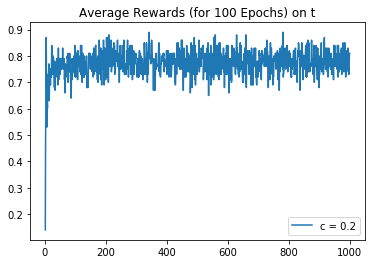

In [3]:
def average_rewards_hist(T = 10, eps = 2):
    # initiate a (eps x t) matrix
    rewards = np.empty([eps, T])

    for ep in range(eps):
        env = Environment()
        agent = Agent()

        t = 0
        while env.time <= T:
            agent.step(env)
            rewards[ep][t] = agent.current_reward
            t += 1
    return np.mean(rewards, axis=0) # average over column


T = 1000
eps = 100
plt.plot(range(1,T+1), average_rewards_hist(T, eps), label= 'c = 0.2')
plt.title('Average Rewards (for {} Epochs) on t'.format(eps))
plt.legend()
plt.show()

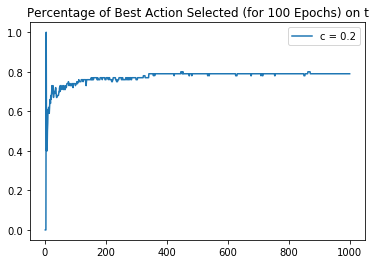

In [4]:
def best_action_hist(T = 10, eps = 2):
    # initiate a (eps x t) matrix
    best_actions = np.empty([eps, T])

    for ep in range(eps):
        env = Environment()
        agent = Agent()

        t = 0
        while env.time <= T:
            agent.step(env)
            best_actions[ep][t] = (agent.selected_action == env.best_action)
            t += 1
    return np.mean(best_actions, axis=0) # average over column


T = 1000
eps = 100
plt.plot(range(1,T+1), best_action_hist(T, eps), label= 'c = 0.2')
plt.title('Percentage of Best Action Selected (for {} Epochs) on t'.format(eps))
plt.legend()
plt.show()

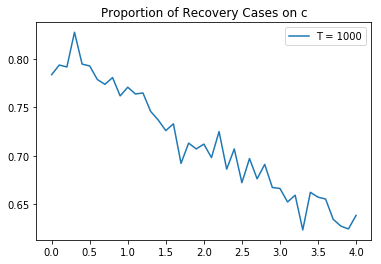

In [6]:
def proportion_recovered(c, T = 10):
    env = Environment()
    agent = Agent(c)
    rewards = []
    while env.time <= T:
        agent.step(env)
        rewards.append(agent.current_reward)
    return np.mean(np.asarray(rewards))


T = 1000
proportion_recovered_by_c = []
all_c = []

for c in range(41):
    c /= 10
    all_c.append(c)
    proportion_recovered_by_c.append(proportion_recovered(c, T))
    

plt.plot(all_c, proportion_recovered_by_c, label= 'T = 1000')
plt.title('Proportion of Recovery Cases on c')
plt.legend()
plt.show()

## Problem 2 (5 points)

In this problem, we consider the optimization of hospital patient flow using the Markov Decision Process. We assume that the hospital can hold 300 patients at most.

Further, we introduce three states as follows:   

"Low" if number of patients is in $[0,100)$   
"Medium" if number of patients is in $[101,200)$   
"High" if number of patients is in $[201,300]$    

Please notice that this aggregation is an improtant step as it allows one to accuratly estimate the transition probabilities from state to state using the database that tracks journeys of patients through the hospital from arrival to discharge.



One time step corresponds to one day and the administration of the hospital can select the following actions:

If the hospital has "Low" number of patients, then $a \in \{0\}$, where $0$ indicates that no patient will be released early.   
If the hospital has "Medium" number of patients, then $a \in \{0,1\}$, i.e. besides action $a=0$, only one additional action is admissible, namely $1$. This action corresponds to releasing $10$ patients early.   
If the hospital has "High" number of patients, then $a \in \{0,1,2\}$, i.e. besides action $a=0$, two additional actions, namely $1$ and $2$, are admissible. Action $a=1$ again corresponds to releasing $10$ patients early, while action $2$ indicates releasing $20$ patients early.  
   
<br>
        
Further, assume that we found the transition probabilities $p(S_{t+1}=s^\prime|S_t=s,A_t=a)$ to be (for a data-driven estimates refer, for instance, to "Markov Decision Process Model for Optimisation of Patient Flow" by Clissold, J. Filar, S. Qin, and D.Ward, 21st International Congress on Modelling and Simulation, Gold Coast, Australia, 29 Nov to 4 Dec 2015):   

$p(S_{t+1}=s^\prime|S_t=s,A_t=0)=\begin{bmatrix} 
0.8 & 0.2 & 0 \\
0.25 & 0.7 & 0.05\\
0.01 & 0.25 & 0.74\\
\end{bmatrix}$    

Here, we use the Markov Chain convention with $s$ being the row index (in the order from "Low" to "Hight"), and $s^\prime$ being the column index.    
For example, $p(S_{t+1}=\text{"High"}|S_t=\text{"Medium"},A_t=0)=0.05$ and $p(S_{t+1}=\text{"Medium"}|S_t=\text{"Low"},A_t=0)=0.2$.

If, however, the hospital decides to release $10$ patients early, i.e. $A_t=1$, the probability of moving to a "lower" hospital occupancy level are now larger, while the probability of moving to a "higher" state are smaller:  

$p(S_{t+1}=s^\prime|S_t=s,A_t=1)=\begin{bmatrix} 
- & - & - \\
0.25+0.1 & 0.7-0.09 & 0.05-0.01\\
0.01+0.01 & 0.25+0.09 & 0.74-0.1\\
\end{bmatrix}$ 

where same $s, s^\prime$ index convention is used. Plase notice that in state $s=\text{"Low"}$ action $A_t=1$ is unavailable resuting in missing probabilities (denoted by "-") in the matrix above. On the other hand, $p(S_{t+1}=\text{"High"}|S_t=\text{"Medium"},A_t=1)=0.05-0.1$, for example.

Finally, if the decision maker selects to reaease $20$ patients early, i.e. $A_t=20$, then   

$p(S_{t+1}=s^\prime|S_t=s,A_t=2)=\begin{bmatrix} 
- & - & - \\
- & - & -\\
0.01+0.02 & 0.25+0.18 & 0.74-0.2\\
\end{bmatrix}.$   
   
<br><br>
        
The reward $R_{t+1}$ obtained as a result of action $A_t$ is defined as follows:   
$R_{t+1}=\frac{1}{10}\left[\mathbb{1}_{\{S_{t+1}=\text{"Low"}\}}\cdot 49.5+\mathbb{1}_{\{S_{t+1}=\text{"Medium"}\}}\cdot 150.5+\mathbb{1}_{\{S_{t+1}=\text{"High"}\}}\cdot 255.5 + A_t\cdot (-10)\right]+\frac{9}{10}\left[\mathbb{1}_{\{S_{t+1}=\text{"High"}\}}\cdot (-30)\right]$.

Here, the first term $\frac{1}{10}\left[\ldots\right]$ is related to the direct profit of the hospital, while the second term $\frac{9}{10}\left[\ldots\right]$ is associated with the inconvenience of patients, risk of refusal for admission of new patients, and the reputation of the hospital.

<br>
Let $\pi$ be the policy to select $a=0$ in states "Low" and "Medium" and $a=2$ in state "High." Please evaluate the policy (that is, estimate $v_\pi$ for all $s$) via the Semi-gradient TD($\lambda$) for estimating $\hat{v}\approx v_\pi$ algorithm (p. 293 of "Reinforcement Learning" by Sutton and Barto). Use $\lambda=0.8$.

In [7]:
import numpy as np
from random import randint


N_STATES = 3

class Environment:
    """
    Hospital patient flow model can take state [0, 1, 2]
    These state corresponds to states based on the number of patients
    ["low", "medium", "high"]
    
    """
    def __init__(self, state = 0):
        self.time = 1
        self.cur_reward = None
        self.action_selected = None
        self.state = state
        self.transition = [
            [[0.8, 0.2, 0],[0.25, 0.7, 0.05],[0.01, 0.25, 0.74]],
            [[None, None, None],[0.35, 0.61, 0.04],[0.02, 0.34, 0.64]],
            [[None, None, None],[None, None, None],[0.03, 0.43, 0.54]]
            ]

    def admissible_actions(self, state):
        return list(range(state + 1))
    
    def all_states(self):
        return [0, 1, 2]
    
    def expect_reward(self, action, new_state):
        assert(new_state in self.all_states())
        return (new_state == 0)*4.95 + (new_state == 1)*15.05 - (new_state == 2)*1.45 - action
    
    def take_action(self, policy):
        action = np.random.choice(self.admissible_actions(self.state), p = policy[self.state])
        transition_prob = self.transition[action][self.state]
        self.state = np.random.choice(list(range(3)), p = transition_prob)
        self.cur_reward = self.expect_reward(action, self.state)
        self.time += 1


def semi_gradient_TDLam_state_eval(v, dv, policy, n_eps = 1000, n_steps = 1000, alpha = 0.0001, gamma = 0.9, lam = 0.8):
    w = np.zeros(N_STATES)
    for _ in range(n_eps):
        z = np.zeros(N_STATES)

        # Initiate environment with a randomly chosen starting state
        env = Environment(randint(0, N_STATES - 1))
        
        while env.time <= n_steps:
            prev_state = env.state
            env.take_action(policy)
            z = gamma * lam * z + dv(prev_state, w)
            delta = env.cur_reward + gamma * v(env.state, w) - v(prev_state, w)
            w = w + alpha * delta * z

    return w

# value function
def v(state, w):
    s = np.array([int(state == s) for s in range(N_STATES)])
    return np.dot(s, w)
# partial derivitive of value function (by w)
def dv(state, w):
    s = np.array([int(state == s) for s in range(N_STATES)])
    return s

w = semi_gradient_TDLam_state_eval(
    v = lambda s, w: v(s, w),
    dv = lambda s, w: dv(s, w),
    policy = [[1], [1, 0], [0, 0, 1]]
)
print([v(s, w) for s in range(N_STATES)])

[84.5180383573807, 92.76377992933952, 79.21815526528307]


## Problem 3 (10 points)

In this problem we consider patients with end-stage liver disease (ESLD). We assume that patient's health condition is fully characterized by the Model for End-stage Liver Disease (MELD) score (Jae-Hyeon Ahn and John Hornberger, Involving patients in the cadaveric kidney transplant allocation process: a decision-theoretic perspective. Manage Sci. 1996;42(5):629–41).

The MELD score ranges from 6 to 40 and is derived based on the probability of survival at 3 months for patients with ESLD. Data in ESLD is usually sparse and often aggregated into Stages. We assume that there are 18 stages based on the ESLD: Stage 1, Stage2, ..., Stage 18. The time step is 1 year and the actions in Stages 1 through 18 are "wait" and "transplant". 

We assume that the Markov property holds. There are three additional states of the Markov Decision Process: "Pretransplant Death", "Posttransplant Life" and "Posttransplant Death" with no actions available. Assume that the length of episodes is T=50. "Pretransplant Death" and "Posttransplant Death" are absorbing states (time stops).

If patient selects "wait", the possible transitions are   
1) Stage 1->Stage 1, Stage 1->Stage 2, Stage 1->Pretransplant Death  
2) For k in {2,3,4,...17}, Stage k->Stage (k-1), Stage k->Stage k, Stage k->Stage (k+1), Stage k->Pretransplant Death  
3) Stage 18->Stage 17, Stage 18->Stage 18, Stage 18->Pretransplant Death

If a patient selects "transplant" in Stage k, k=1,2,...,18, the only possible transition is  
4) Stage k->"Posttransplant Life"

Finally, there is the transition  
5) "Posttransplant Life"->"Posttransplant Death"  

Assume that   

P(Stage (k+1)|Stage k, "wait")=0.10 for k=1,2,...,17  
P(Stage (k-1)|Stage k, "wait")=0.02 for k=2,3,...,18  

P(Pretransplant Death|Stage k, "wait")=k*c for k=1,2,...,18 and some constant c.  

P(Stage k|Stage k, "wait")=0.9-kc for k=1   
P(Stage k|Stage k, "wait")=0.98-kc for k=18   
P(Stage k|Stage k, "wait")=0.88-kc for k=2,...,17   

Further, assume that   
P(Posttransplant Death|Posttransplant Life)= 4*c for the same constant c.


The patient gets reward 1 in all states "Stage k" (k=1,2,...,18) and reward 0.2 in the "Posttransplant Life" state. We assume the discounting parameter $\gamma=0.97$, one of the most common discounting rate used in medical decision making (Gold MR, Siegel JE, Russell LB, Weinstein MC. Cost-Effectiveness in Health and Medicine. Oxford University Press; New York: 1996).

<br>

Let $\pi$ be the policy to select "wait" in states Stage 1 through Stage 15 and "transplant" in states Stage 16 through Stage 18. Estimate $v_\pi$ for Stages 1 through 18 as follows:    

1) Let vector of features, ${\bf x}(\text{Stage k})$, be a vector of length 18 with all 0's but 1 in the k-th position: ${\bf x}(\text{Stage k})=(0,0,\ldots,0,1,0,\ldots,0)^T$. Using the policy $\pi$, generate a set $\langle {\bf x}(\text{Stage k}),G \rangle$, where $G$ is the return (cumulative discounted reward) that corresponds to a visit to state $\text{Stage k}$. Generate $n=4000$ samples.   

2) Use Keras to build Deep Neural Network with 2 hidden layers for predicting $G$ based on input ${\bf x}(\text{Stage k})$. Try a few options for the numbers of neurons and regularization methods (dropout and L1/L2 norms). Pick the best option (based on validation error) you found. Plot the training and validation error versus number of training epochs.   

3) Use the Neural Network you built to plot estimated $v_\pi(\text{Stage k})$ versus k for k=1,2,...,18.

In [8]:
import numpy as np
import random

ESLD_STAGES = list(range(1, 19))

class ESLD:
    def __init__(self, stage, c = 0.015):
        """
        Generate an ESLD model for a patient in stage 1-18 of ESLD.

        If the patient is outside of stage 1-18, the patient is either dead
        or in "posttransplant life stage", which is represented as stage 0.

        Death is the terminal state of this model, it is stored as self.state = None.
        Initialising a dead patient is not a valid input.
        
        """
        assert stage in range(19), "stage must be 0-18 for live patient"
        self.state = stage
        self.c = c
        self.time = 0

    def admissible_actions(self):
        """ return all admissible actions for a state in the form of a list """
        if self.state in ESLD_STAGES:
            return [0, 1] # 0 correspond to "wait", 1 correspond to "transplant"
        elif self.state == 0:
            return [None]
        else:
            print(type(self.state))
            raise (Error, "state should not exist")
    
    def is_terminal(self):
        return self.state == "ND" or self.state == "TD"

    def get_reward(self, action):
        if action == None:
            # posttransplant life
            assert self.state == 0, "action only valid for post-transplant life"
            self.state = np.random.choice(["0", "TD"], p = [1 - 4*self.c, 4*self.c])

            if self.state == "0":
                self.state = int(self.state)
                reward = 0.2
            else:
                # posttransplant death
                reward = 0

        elif action == 1:
            # transplant action
            self.state = 0
            reward = 0.2

        elif action == 0:
            # wait action
            new_states = [self.state-1, self.state, self.state+1, "ND"]
            p_new_states = [0.02, 0.88-self.c*self.state, 0.1, self.c*self.state]
    
            if self.state == 1:
                p_new_states[1] += 0.02
                del new_states[0]
                del p_new_states[0]
            elif self.state == 18:
                p_new_states[1] += 0.1
                del new_states[-2]
                del p_new_states[-2]

            self.state = np.random.choice(new_states, p = p_new_states)

            if self.state == "ND":
                # pretransplant (natural) death
                reward = 0
            else:
                self.state = int(self.state)
                reward = 1

        else:
            raise (TypeError, "action", action, "is invalid for", self.state)

        self.time += 1
        return reward


def generate_ESLD_episode(policy, stage = None):
    if not stage:
        stage = random.choice(ESLD_STAGES)
    else:
        assert stage in ESLD_STAGES
    env = ESLD(stage)
    record = {"s":[], "a":[], "r":[]}

    while True:
        record["s"].append(env.state)

        selected_action = np.random.choice(env.admissible_actions(), p = policy[env.state])
        record["a"].append(selected_action)

        reward = env.get_reward(selected_action)
        record["r"].append(reward)

        if env.is_terminal() or env.time >= 100: # patient lives no longer than 100 years post diagnosis
            return record


def generate_data_set(policy, limit = 4000, gamma = 0.97):
    data_set = []
    n_eps = 0
    while len(data_set) < limit:
        n_eps += 1
        G = 0
        episode = generate_ESLD_episode(policy, (n_eps%len(ESLD_STAGES) +1))
        for t in range(-1, -len(episode["r"])-1, -1):
            G = gamma*G + episode["r"][t]
            s = episode["s"][t]
            if s:
                x = tuple(int(s == k) for k in ESLD_STAGES)
                data_set.append([x, G])
            if len(data_set) == limit:
                break

    return data_set

# Specify policy
policy = {}
for state in ESLD_STAGES:
    if state < 15:
        policy[state] = [1, 0]
    elif state < 19:
        policy[state] = [0, 1]
    else:
        raise Error # state is outside of the defined range
    policy[0] = [1]  # policy for posttransplant life is 100% pass


data_set = generate_data_set(policy)

## Training Data
The 4000 data entries are split into two sets for training and testing purposes - both sets have the same distribution of input x

In [10]:
# start a frequency dictionary for sampling purpose
freq = {f:0 for f in tuple(tuple(int(s == k) for k in ESLD_STAGES) for s in ESLD_STAGES)}
for feature, reward in data_set:
    freq[feature] += 1

n = len(data_set)//2
f = sum(freq.values())
for key in freq.keys():
    freq[key] = round(freq[key]/f * n)
    assert freq[key] >= 2, "assume frequency of each state is enough to be create at least one test and one training sample"


x_test = []
y_test = []
tfreq = {f:0 for f in tuple(tuple(int(s == k) for k in ESLD_STAGES) for s in ESLD_STAGES)}
x_train = []
y_train = []
for feature, reward in data_set:
    if tfreq[feature] < freq[feature]:
        # Append training data
        x_train.append(np.asarray(feature))
        y_train.append(reward)
        tfreq[feature] += 1
    else:
        # Append testing data
        x_test.append(np.asarray(feature))
        y_test.append(reward)

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)            
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

## Raw NN Models

In [11]:
from keras import layers
from keras import models
from keras import regularizers


# Creating Models
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape = (len(ESLD_STAGES),) ))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='relu'))
model.summary()

# Training
nepochs = 60
model.compile(optimizer='rmsprop',
              loss='mae',
              metrics=['mae'])
history = model.fit(x_train, y_train,
          epochs=nepochs,
          batch_size=64,
          validation_data=(x_test, y_test))

history_dict0_1 = history.history

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                608       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,697
Trainable params: 1,697
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 2001 samples, validate on 1999 samples
Epoch 1/60
2001/2001 [==============================] - 0s 183us/step - loss: 8.9129 - mean_absolute_error: 8.9129 - val_loss: 7.0943 - val_mean_absolute_error: 7.0943
Epoch 2/60
2001/2001 [==============================] - 0s 33us/step

Epoch 42/60
2001/2001 [==============================] - 0s 48us/step - loss: 4.7738 - mean_absolute_error: 4.7738 - val_loss: 5.1655 - val_mean_absolute_error: 5.1655
Epoch 43/60
2001/2001 [==============================] - 0s 45us/step - loss: 4.7763 - mean_absolute_error: 4.7763 - val_loss: 5.1832 - val_mean_absolute_error: 5.1832
Epoch 44/60
2001/2001 [==============================] - 0s 50us/step - loss: 4.7742 - mean_absolute_error: 4.7742 - val_loss: 5.2239 - val_mean_absolute_error: 5.2239
Epoch 45/60
2001/2001 [==============================] - 0s 53us/step - loss: 4.7750 - mean_absolute_error: 4.7750 - val_loss: 5.2180 - val_mean_absolute_error: 5.2180
Epoch 46/60
2001/2001 [==============================] - 0s 51us/step - loss: 4.7758 - mean_absolute_error: 4.7758 - val_loss: 5.1796 - val_mean_absolute_error: 5.1796
Epoch 47/60
2001/2001 [==============================] - 0s 46us/step - loss: 4.7752 - mean_absolute_error: 4.7752 - val_loss: 5.1781 - val_mean_absolute_error:

In [12]:
# Creating Models
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape = (len(ESLD_STAGES),) ))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='relu'))
model.summary()

# Training
nepochs = 60
model.compile(optimizer='rmsprop',
              loss='mae',
              metrics=['mae'])
history = model.fit(x_train, y_train,
          epochs=nepochs,
          batch_size=64,
          validation_data=(x_test, y_test))

history_dict0_2 = history.history

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                1216      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0
_________________________________________________________________
Train on 2001 samples, validate on 1999 samples
Epoch 1/60
2001/2001 [==============================] - 0s 215us/step - loss: 8.6708 - mean_absolute_error: 8.6708 - val_loss: 6.5422 - val_mean_absolute_error: 6.5422
Epoch 2/60
2001/2001 [==============================] - 0s 46us/step - loss: 7.1635 - mean_absolute_error: 7.1635 - val_loss: 5.6482 - val_mean_absolute_error: 5.6482
Epoch 3/60
2001/2001 

In [13]:
# Creating Models
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape = (len(ESLD_STAGES),) ))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='relu'))
model.summary()

# Training
nepochs = 60
model.compile(optimizer='rmsprop',
              loss='mae',
              metrics=['mae'])
history = model.fit(x_train, y_train,
          epochs=nepochs,
          batch_size=64,
          validation_data=(x_test, y_test))

history_dict0_3 = history.history

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 16)                304       
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 593
Trainable params: 593
Non-trainable params: 0
_________________________________________________________________
Train on 2001 samples, validate on 1999 samples
Epoch 1/60
2001/2001 [==============================] - 1s 265us/step - loss: 9.1651 - mean_absolute_error: 9.1651 - val_loss: 7.5595 - val_mean_absolute_error: 7.5595
Epoch 2/60
2001/2001 [==============================] - 0s 50us/step - loss: 8.7708 - mean_absolute_error: 8.7708 - val_loss: 7.1722 - val_mean_absolute_error: 7.1722
Epoch 3/60
2001/2001 [===

In [14]:
# Creating Models
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape = (len(ESLD_STAGES),) ))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='relu'))
model.summary()

# Training
nepochs = 60
model.compile(optimizer='rmsprop',
              loss='mae',
              metrics=['mae'])
history = model.fit(x_train, y_train,
          epochs=nepochs,
          batch_size=64,
          validation_data=(x_test, y_test))

history_dict0_4 = history.history

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 16)                304       
_________________________________________________________________
dense_11 (Dense)             (None, 64)                1088      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 1,457
Trainable params: 1,457
Non-trainable params: 0
_________________________________________________________________
Train on 2001 samples, validate on 1999 samples
Epoch 1/60
2001/2001 [==============================] - 1s 257us/step - loss: 9.0178 - mean_absolute_error: 9.0178 - val_loss: 7.2314 - val_mean_absolute_error: 7.2314
Epoch 2/60
2001/2001 [==============================] - 0s 48us/step - loss: 8.2373 - mean_absolute_error: 8.2373 - val_loss: 6.5290 - val_mean_absolute_error: 6.5290
Epoch 3/60
2001/2001 

In [15]:
# Creating Models
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape = (len(ESLD_STAGES),) ))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='relu'))
model.summary()

# Training
nepochs = 60
model.compile(optimizer='rmsprop',
              loss='mae',
              metrics=['mae'])
history = model.fit(x_train, y_train,
          epochs=nepochs,
          batch_size=64,
          validation_data=(x_test, y_test))

history_dict0_5 = history.history

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 64)                1216      
_________________________________________________________________
dense_14 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total params: 2,273
Trainable params: 2,273
Non-trainable params: 0
_________________________________________________________________
Train on 2001 samples, validate on 1999 samples
Epoch 1/60
2001/2001 [==============================] - 1s 302us/step - loss: 9.1805 - mean_absolute_error: 9.1805 - val_loss: 7.4637 - val_mean_absolute_error: 7.4637
Epoch 2/60
2001/2001 [==============================] - 0s 47us/step - loss: 8.5379 - mean_absolute_error: 8.5379 - val_loss: 6.8313 - val_mean_absolute_error: 6.8313
Epoch 3/60
2001/2001 

## Determine Number of Neurons

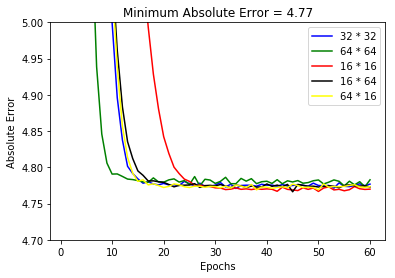

In [22]:
plt.clf()   # clear figure
val_acc_values0 = history_dict0_1['mean_absolute_error']
val_acc_values1 = history_dict0_2['mean_absolute_error']
val_acc_values2 = history_dict0_3['mean_absolute_error']
val_acc_values3 = history_dict0_4['mean_absolute_error']
val_acc_values4 = history_dict0_5['mean_absolute_error']

plt.plot(range(1,nepochs+1), val_acc_values0, 'b', label='32 * 32',color="blue")
plt.plot(range(1,nepochs+1), val_acc_values1, 'b', label='64 * 64',color="green")
plt.plot(range(1,nepochs+1), val_acc_values2, 'b', label='16 * 16',color="red")
plt.plot(range(1,nepochs+1), val_acc_values3, 'b', label='16 * 64',color="black")
plt.plot(range(1,nepochs+1), val_acc_values4, 'b', label='64 * 16',color="yellow")


plt.ylim((4.7, 5))
plt.title('Minimum Absolute Error = '+ str(round(min(val_acc_values0+val_acc_values1+val_acc_values2+val_acc_values3+val_acc_values4),2)))
plt.xlabel('Epochs')
plt.ylabel('Absolute Error')
plt.legend()

plt.show()

The graph shows many numerical combination of neurons produce the similar level of errors. More neurons can lead to faster convergence, less neurons can have small improvements in accuracy. 16 * 16 hidden layering is selected for our NN.

A similar investigation was conducted for the batch size and same level of convergence is observed.

## L1 Normalisation

In [23]:
# Creating Models
lam = 0.0001

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l1(lam), input_shape = (len(ESLD_STAGES),) ))
model.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l1(lam)))
model.add(layers.Dense(1, activation='relu'))
model.summary()

# Training
nepochs = 60
model.compile(optimizer='rmsprop',
              loss='mae',
              metrics=['mae'])
history = model.fit(x_train, y_train,
          epochs=nepochs,
          batch_size=64,
          validation_data=(x_test, y_test))

history_dict1 = history.history

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 16)                304       
_________________________________________________________________
dense_17 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 17        
Total params: 593
Trainable params: 593
Non-trainable params: 0
_________________________________________________________________
Train on 2001 samples, validate on 1999 samples
Epoch 1/60
2001/2001 [==============================] - 1s 419us/step - loss: 9.0413 - mean_absolute_error: 9.0300 - val_loss: 7.3926 - val_mean_absolute_error: 7.3814
Epoch 2/60
2001/2001 [==============================] - 0s 46us/step - loss: 8.5000 - mean_absolute_error: 8.4889 - val_loss: 6.8499 - val_mean_absolute_error: 6.8389
Epoch 3/60
2001/2001 [===

## L2 Normalization

In [138]:
# Creating Models
lam = 0.0001

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(lam), input_shape = (len(ESLD_STAGES),) ))
model.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(lam)))
model.add(layers.Dense(1, activation='relu'))
model.summary()

# Training
nepochs = 60
model.compile(optimizer='rmsprop',
              loss='mae',
              metrics=['mae'])
history = model.fit(x_train, y_train,
          epochs=nepochs,
          batch_size=64,
          validation_data=(x_test, y_test))

history_dict2 = history.history

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_139 (Dense)            (None, 16)                304       
_________________________________________________________________
dense_140 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_141 (Dense)            (None, 1)                 17        
Total params: 593
Trainable params: 593
Non-trainable params: 0
_________________________________________________________________


ValueError: Error when checking input: expected dense_139_input to have shape (18,) but got array with shape (7,)

## Determine Regularization

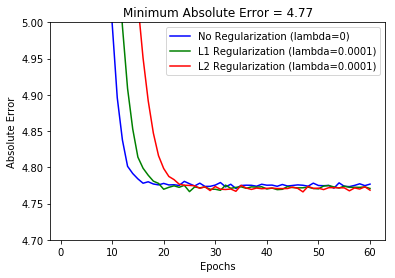

In [26]:
plt.clf()   # clear figure
val_acc_values0 = history_dict0_1['mean_absolute_error']
val_acc_values1 = history_dict1['mean_absolute_error']
val_acc_values2 = history_dict2['mean_absolute_error']

plt.plot(range(1,nepochs+1), val_acc_values0, 'b', label='No Regularization (lambda=0)',color="blue")
plt.plot(range(1,nepochs+1), val_acc_values1, 'b', label='L1 Regularization (lambda=0.0001)',color="green")
plt.plot(range(1,nepochs+1), val_acc_values2, 'b', label='L2 Regularization (lambda=0.0001)',color="red")


plt.ylim((4.7, 5))
plt.title('Minimum Absolute Error = '+ str(round(min(val_acc_values0+val_acc_values1+val_acc_values2),2)))
plt.xlabel('Epochs')
plt.ylabel('Absolute Error')
plt.legend()

plt.show()

The result of regularization converges to a similar minimum error with rate slower than training without regularization. However, the result with regularization apperas to converge to a slightly lower error level, so L2 regularization is used for the final NN model.

## Dropout

In [27]:
# Creating Models
dropout_rate = 0.1
lam = 0.0001

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(lam), input_shape = (len(ESLD_STAGES),) ))
model.add(layers.Dropout(dropout_rate))
model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(lam), activation='relu'))
model.add(layers.Dropout(dropout_rate))
model.add(layers.Dense(1, activation='relu'))
model.summary()

# Training
nepochs = 100
model.compile(optimizer='rmsprop',
              loss='mae',
              metrics=['mae'])
history = model.fit(x_train, y_train,
          epochs=nepochs,
          batch_size=64,
          validation_data=(x_test, y_test))

history_dict_d3 = history.history

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 16)                304       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 17        
Total params: 593
Trainable params: 593
Non-trainable params: 0
_________________________________________________________________
Train on 2001 samples, valida

2001/2001 [==============================] - 0s 58us/step - loss: 4.8849 - mean_absolute_error: 4.8808 - val_loss: 5.2055 - val_mean_absolute_error: 5.2014
Epoch 90/100
2001/2001 [==============================] - 0s 54us/step - loss: 4.8563 - mean_absolute_error: 4.8522 - val_loss: 5.2082 - val_mean_absolute_error: 5.2041
Epoch 91/100
2001/2001 [==============================] - 0s 57us/step - loss: 4.8667 - mean_absolute_error: 4.8627 - val_loss: 5.1838 - val_mean_absolute_error: 5.1798
Epoch 92/100
2001/2001 [==============================] - 0s 56us/step - loss: 4.9003 - mean_absolute_error: 4.8963 - val_loss: 5.2147 - val_mean_absolute_error: 5.2107
Epoch 93/100
2001/2001 [==============================] - 0s 55us/step - loss: 4.8666 - mean_absolute_error: 4.8626 - val_loss: 5.2448 - val_mean_absolute_error: 5.2407
Epoch 94/100
2001/2001 [==============================] - 0s 52us/step - loss: 4.8654 - mean_absolute_error: 4.8613 - val_loss: 5.1490 - val_mean_absolute_error: 5.1450

In [28]:
# Creating Models
dropout_rate = 0.2
lam = 0.0001

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(lam), input_shape = (len(ESLD_STAGES),) ))
model.add(layers.Dropout(dropout_rate))
model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(lam), activation='relu'))
model.add(layers.Dropout(dropout_rate))
model.add(layers.Dense(1, activation='relu'))
model.summary()

# Training
nepochs = 100
model.compile(optimizer='rmsprop',
              loss='mae',
              metrics=['mae'])
history = model.fit(x_train, y_train,
          epochs=nepochs,
          batch_size=64,
          validation_data=(x_test, y_test))

history_dict_d5 = history.history

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 16)                304       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 17        
Total params: 593
Trainable params: 593
Non-trainable params: 0
_________________________________________________________________
Train on 2001 samples, validate on 1999 samples
Epoch 1/100
2001/2001 [==============================] - 1s 480us/step - loss: 9.2423 - mean_abs

2001/2001 [==============================] - 0s 51us/step - loss: 5.0238 - mean_absolute_error: 5.0198 - val_loss: 5.1151 - val_mean_absolute_error: 5.1111
Epoch 92/100
2001/2001 [==============================] - 0s 54us/step - loss: 4.9094 - mean_absolute_error: 4.9054 - val_loss: 5.1116 - val_mean_absolute_error: 5.1076
Epoch 93/100
2001/2001 [==============================] - 0s 54us/step - loss: 5.0339 - mean_absolute_error: 5.0299 - val_loss: 5.0833 - val_mean_absolute_error: 5.0793
Epoch 94/100
2001/2001 [==============================] - 0s 50us/step - loss: 5.0379 - mean_absolute_error: 5.0339 - val_loss: 5.0785 - val_mean_absolute_error: 5.0745
Epoch 95/100
2001/2001 [==============================] - 0s 56us/step - loss: 5.0220 - mean_absolute_error: 5.0180 - val_loss: 5.0792 - val_mean_absolute_error: 5.0752
Epoch 96/100
2001/2001 [==============================] - 0s 50us/step - loss: 5.0049 - mean_absolute_error: 5.0009 - val_loss: 5.0845 - val_mean_absolute_error: 5.0805

In [29]:
# Creating Models
dropout_rate = 0.5
lam = 0.0001

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(lam), input_shape = (len(ESLD_STAGES),) ))
model.add(layers.Dropout(dropout_rate))
model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(lam), activation='relu'))
model.add(layers.Dropout(dropout_rate))
model.add(layers.Dense(1, activation='relu'))
model.summary()

# Training
nepochs = 100
model.compile(optimizer='rmsprop',
              loss='mae',
              metrics=['mae'])
history = model.fit(x_train, y_train,
          epochs=nepochs,
          batch_size=64,
          validation_data=(x_test, y_test))

history_dict_d7 = history.history

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 16)                304       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 64)                1088      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 65        
Total params: 1,457
Trainable params: 1,457
Non-trainable params: 0
_________________________________________________________________
Train on 2001 samples, validate on 1999 samples
Epoch 1/100
2001/2001 [==============================] - 1s 552us/step - loss: 9.1800 - mean

2001/2001 [==============================] - 0s 53us/step - loss: 5.0612 - mean_absolute_error: 5.0572 - val_loss: 5.1296 - val_mean_absolute_error: 5.1256
Epoch 92/100
2001/2001 [==============================] - 0s 57us/step - loss: 5.1728 - mean_absolute_error: 5.1688 - val_loss: 5.1332 - val_mean_absolute_error: 5.1291
Epoch 93/100
2001/2001 [==============================] - 0s 59us/step - loss: 5.1470 - mean_absolute_error: 5.1430 - val_loss: 5.1238 - val_mean_absolute_error: 5.1197
Epoch 94/100
2001/2001 [==============================] - 0s 58us/step - loss: 5.1512 - mean_absolute_error: 5.1472 - val_loss: 5.0888 - val_mean_absolute_error: 5.0848
Epoch 95/100
2001/2001 [==============================] - 0s 47us/step - loss: 5.1088 - mean_absolute_error: 5.1048 - val_loss: 5.1170 - val_mean_absolute_error: 5.1130
Epoch 96/100
2001/2001 [==============================] - 0s 53us/step - loss: 5.1321 - mean_absolute_error: 5.1280 - val_loss: 5.0997 - val_mean_absolute_error: 5.0958

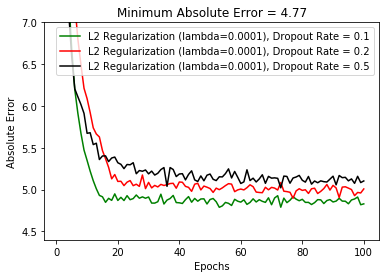

In [32]:
plt.clf()   # clear figure
val_acc_values0 = history_dict2['mean_absolute_error']
val_acc_values1 = history_dict_d3['mean_absolute_error']
val_acc_values2 = history_dict_d5['mean_absolute_error']
val_acc_values3 = history_dict_d7['mean_absolute_error']

#plt.plot(range(1,nepochs+1), val_acc_values0, 'b', label='L1 Regularization (lambda=0.0001), No Dropouts',color="blue")
plt.plot(range(1,nepochs+1), val_acc_values1, 'b', label='L2 Regularization (lambda=0.0001), Dropout Rate = 0.1',color="green")
plt.plot(range(1,nepochs+1), val_acc_values2, 'b', label='L2 Regularization (lambda=0.0001), Dropout Rate = 0.2',color="red")
plt.plot(range(1,nepochs+1), val_acc_values3, 'b', label='L2 Regularization (lambda=0.0001), Dropout Rate = 0.5',color="black")


plt.ylim((4.4, 7))
plt.title('Minimum Absolute Error = '+ str(round(min(val_acc_values0+val_acc_values1+val_acc_values2+val_acc_values3),2)))
plt.xlabel('Epochs')
plt.ylabel('Absolute Error')
plt.legend()

plt.show()

Dropout does not appear to improve the optimal performance (4.77) of the NN on training set. No dropout would be used for final model

## Validation vs Training Errors

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 16)                304       
_________________________________________________________________
dense_32 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 17        
Total params: 593
Trainable params: 593
Non-trainable params: 0
_________________________________________________________________
Train on 2001 samples, validate on 4000 samples
Epoch 1/60
2001/2001 [==============================] - 1s 499us/step - loss: 9.2488 - mean_absolute_error: 9.2456 - val_loss: 8.0209 - val_mean_absolute_error: 8.0178
Epoch 2/60
2001/2001 [==============================] - 0s 60us/step - loss: 8.8309 - mean_absolute_error: 8.8279 - val_loss: 7.5610 - val_mean_absolute_error: 7.5580
Epoch 3/60
2001/2001 [===

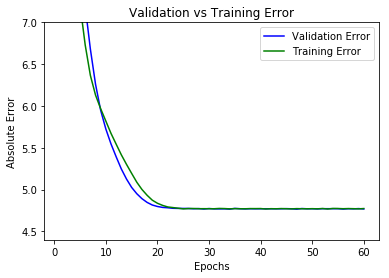

In [33]:
# Generate a new dataset for testing error
data_set = generate_data_set(policy)
x_input = []
y_input = []

for feature, reward in data_set:
    x_input.append(np.asarray(feature))
    y_input.append(reward)

x_input = np.asarray(x_input)
y_input = np.asarray(y_input)

# Reconstruct L2 Regularization Model
lam = 0.0001

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(lam), input_shape = (len(ESLD_STAGES),) ))
model.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(lam)))
model.add(layers.Dense(1, activation='relu'))
model.summary()

# Validating
nepochs = 60
model.compile(optimizer='rmsprop',
              loss='mae',
              metrics=['mae'])
history = model.fit(x_train, y_train,
          epochs=nepochs,
          batch_size=64,
          validation_data=(x_input, y_input))

history_dict_final = history.history

plt.clf()   # clear figure
val_acc_values0 = history_dict2['mean_absolute_error']
val_acc_values1 = history_dict_final['mean_absolute_error']

plt.plot(range(1,nepochs+1), val_acc_values0, 'b', label='Validation Error',color="blue")
plt.plot(range(1,nepochs+1), val_acc_values1, 'b', label='Training Error',color="green")


plt.ylim((4.4, 7))
plt.title('Validation vs Training Error')
plt.xlabel('Epochs')
plt.ylabel('Absolute Error')
plt.legend()

plt.show()

## State Value Evaluation

State Values:


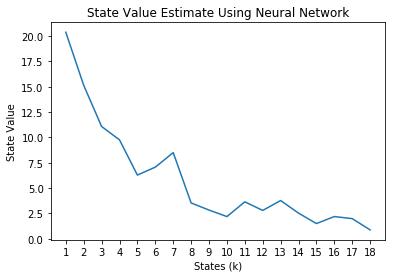

In [57]:
x_input = np.asarray([np.asarray([int(s == k) for k in ESLD_STAGES]) for s in ESLD_STAGES])
v = model.predict(x_input)

plt.clf()   # clear figure

plt.plot(ESLD_STAGES, v)


plt.title('State Value Estimate Using Neural Network')
plt.xlabel('States (k)')
plt.ylabel('State Value')
plt.xticks(np.arange(1, len(ESLD_STAGES)+1, 1))

plt.show()

## Problem 4 (10 points)
Antiviral drugs are used for treating viral infections. The procedure often requires a sequence of treatments. Over time patients develop resistance to the drugs and need to keep switching them. Moreover, a drug of type 1 can make the patient (partially) resistant to the drug of type 2.

In this problem we consider drugs of type A, B, and C, all of which can potentially lower the viral load but the effect depends on their order. The 'Viral_load.xlsx' dataset provides results for 1,000 of patients, where rewards (based on the observed viral load level of patients) indicate the effectiveness of the preceding drugs used. For example, the first patient used drugs A, B, and C in this order and received the following rewards: 14.9062033, 13.67860579, and 12.76096513, respectively.

Because of the antiviral drug resistance, same drug cannot be used twice. The policy (behavior policy $b$) that was used for treatments represented in the 'Viral_load.xlsx' dataset is

1) if all drugs are available, pick A with probability 0.7, B with probability 0.2, and C with probability 0.1   
2) if all drugs, but A, are available, pick B with probability 0.65 and C with probability 0.35   
3) if all drugs, but B, are available, pick A with probability 0.9 and C with probability 0.1  
4) if all drugs, but C, are available, pick A with probability 0.8 and B with probability 0.2   
5) if only one drug is available, pick it with probability 1    



One can find that based on these observations, the optimal order of the treatment is B, A, and then C, indicating that drug A diminishes the effect of drug B, and C diminishes the effect of drug A (and possibly B).

The sequence of treatments can be represented as a Markov Decision Process (MDP). Clearly, the set of available actions at time t depends on the intire history. In order to model the treatment proceedure with the MDP, we introduce states as follows:

1) $S_{ABC}=${all drugs are available}   
2) $S_{BC}=${all drugs, except A, are available}   
3) $S_{AC}=${all drugs, except B, are available}       
4) $S_{AB}=${all drugs, except C, are available}   
5) $S_{A}=${only A is available}   
6) $S_{B}=${only B is available}   
7) $S_{C}=${only C is available}      

The optimal policy $\pi$, that corresponds to the sequence B, A, C, is then: (1) select B in state $S_{ABC}$; (2) select A in state $S_{AC}$; (3) select C in state $S_{C}$.   


Using 'Viral_load.xlsx' dataset, estimate $v_\pi$ for $s\in\{s_{ABC},s_{AC},s_{C}\}$ as follows:    

1) Let vector of features ${\bf x}(s)=(\mathbb{1}_{s=S_{ABC}},\mathbb{1}_{s=S_{BC}},\mathbb{1}_{s=S_{AC}},\mathbb{1}_{s=S_{AB}},\mathbb{1}_{s=S_{A}},\mathbb{1}_{s=S_{B}},\mathbb{1}_{s=S_{C}})$. Create the dataset $\langle {\bf x} ,\rho G \rangle$, where $G$ is the return (cumulative discounted reward) that corresponds to a visit to state $s$ and $\rho$ is the importance-sampling ratio that corresponds to MC. Use $\gamma=0.9$.   

2) Use Keras to build Deep Neural Network with 2 hidden layers for predicting $G$ based on input ${\bf x}(s)$. Try a few options for the numbers of neurons and regularization methods (dropout and L1/L2 norms). Pick the best option (based on validation error) you found. Plot the training and validation error versus number of training epochs.   

3) Use the Neural Network you built to report estimated $v_\pi(s)$ for $s\in\{s_{ABC},s_{AC},s_{C}\}$.


In [1]:
import numpy as np
import csv


ALL_STATES = ["ABC", "BC", "AC", "AB", "A", "B", "C"]


# define policies
b = {
    'ABC': {'A': 0.7, 'B': 0.2, 'C': 0.1},
    'BC': {'B': 0.65, 'C': 0.35},
    'AC': {'A': 0.9, 'C': 0.1},
    'AB': {'A': 0.8, 'B': 0.2},
    'A': {'A': 1},
    'B': {'B': 1},
    'C': {'C': 1}
    }

pi = {"ABC": 'B',
     "AC": 'A',
     "C": 'C'}

def rho(S, A, b = b, pi = pi):
    """
    Returns the importance sampling ratio for optimistic policy pi and behavioral policy b given
    a sequence of states and actions in lists.
    S = [S_t, S_(t+1), ...., S_(T-1), S_T]
    A = [A_t, A_(t+1), ...., A_(T-1), A_T]
    Pi should be an admissible, non-empty, and deterministic policy.
    
    """
    assert len(S) == len(A)

    r = 1
    for k in range(len(S)):
        if S[k] in pi.keys():
            if A[k] == pi[S[k]]:
                r *= 1/b[S[k]][A[k]]
            else:
                return 0
        else:
            return 0
    return r


def read_viral_data(path, gamma = 0.9):
    data_set = []

    csv_file = open(path) # file closed upon return statement
    reader = csv.reader(csv_file)
    next(reader) # skip header row

    while True:
        try:
            episode = next(reader)[1:]
            states = ["ABC"]
            actions = []
            rewards = []
            for t in range(len(states[0])):
                actions.append(episode[t*2])
                rewards.append(float(episode[t*2+1]))
                new_state = states[t].replace(actions[t], '')
                if new_state:
                    states.append(new_state)

            G = 0
            for t in range(-1, -len(states)-1, -1):
                t = t + len(states)
                G = rewards[t] + gamma*G
                features = np.array([int(state == states[t]) for state in ALL_STATES])
                assert sum(features) == 1
                data_set.append([features, rho(states[:t+1], actions[:t+1])*G])

        # reached final episode
        except StopIteration:
            csv_file.close()
            return data_set


data_set = read_viral_data("Viral_load.csv")

## Training Data
30% of the data entries are split into two sets for training and testing purposes - both sets have the same distribution of input x

In [93]:
# start a frequency dictionary for sampling purpose
freq = {f:0 for f in tuple(tuple(int(s == k) for k in ALL_STATES) for s in ALL_STATES)}
for feature, reward in data_set:
    feature = tuple(feature)
    freq[feature] += 1

# Use 50% of the dataset for training/testing
prop = 0.5
n = len(data_set)*prop//2
f = sum(freq.values())
for key in freq.keys():
    freq[key] = round(freq[key]/f * n)
    assert freq[key] >= 2, "assume frequency of each state is enough to be create at least one test and one training sample"

# Create training/testing data
x_test = []
y_test = []
test_freq = {f:0 for f in tuple(tuple(int(s == k) for k in ALL_STATES) for s in ALL_STATES)}
x_train = []
y_train = []
train_freq = {f:0 for f in tuple(tuple(int(s == k) for k in ALL_STATES) for s in ALL_STATES)}
x_input = []
y_input = []
for feature, reward in data_set:
    feature = tuple(feature)
    if test_freq[feature] < freq[feature]:
        # Append training data
        x_train.append(np.asarray(feature))
        y_train.append(reward)
        test_freq[feature] += 1
    elif train_freq[feature] < freq[feature]:
        # Append testing data
        x_test.append(np.asarray(feature))
        y_test.append(reward)
        train_freq[feature] += 1
    else:
        x_input.append(np.asarray(feature))
        y_input.append(reward)

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
x_input = np.asarray(x_input)
y_input = np.asarray(y_input)

## Creating Neural Network

In [66]:
from keras import layers
from keras import models
from keras import regularizers

converge = False
while not converge:
    # Creating Models
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape = (len(ALL_STATES),) ))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='relu'))
    model.summary()

    # Training
    nepochs = 150
    model.compile(optimizer='rmsprop',
                  loss='mae',
                  metrics=['mae'])
    history = model.fit(x_train, y_train,
              epochs=nepochs,
              batch_size=32,
              validation_data=(x_test, y_test))

    history_dict0_1 = history.history
    if history_dict0_1['mean_absolute_error'][-1] < 20:
        converge = True

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_121 (Dense)            (None, 16)                128       
_________________________________________________________________
dense_122 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_123 (Dense)            (None, 1)                 17        
Total params: 417
Trainable params: 417
Non-trainable params: 0
_________________________________________________________________
Train on 750 samples, validate on 750 samples
Epoch 1/150
750/750 [==============================] - 2s 3ms/step - loss: 25.8805 - mean_absolute_error: 25.8805 - val_loss: 29.2878 - val_mean_absolute_error: 29.2878
Epoch 2/150
750/750 [==============================] - 0s 114us/step - loss: 25.8553 - mean_absolute_error: 25.8553 - val_loss: 29.2794 - val_mean_absolute_error: 29.2794
Epoch 3/150
750/750 [=

750/750 [==============================] - 0s 234us/step - loss: 23.5479 - mean_absolute_error: 23.5479 - val_loss: 27.0093 - val_mean_absolute_error: 27.0093
Epoch 45/150
750/750 [==============================] - 0s 212us/step - loss: 23.4134 - mean_absolute_error: 23.4134 - val_loss: 26.8886 - val_mean_absolute_error: 26.8886
Epoch 46/150
750/750 [==============================] - 0s 238us/step - loss: 23.2701 - mean_absolute_error: 23.2701 - val_loss: 26.7391 - val_mean_absolute_error: 26.7391
Epoch 47/150
750/750 [==============================] - 0s 242us/step - loss: 23.1198 - mean_absolute_error: 23.1198 - val_loss: 26.6041 - val_mean_absolute_error: 26.6041
Epoch 48/150
750/750 [==============================] - 0s 228us/step - loss: 22.9726 - mean_absolute_error: 22.9726 - val_loss: 26.4685 - val_mean_absolute_error: 26.4685
Epoch 49/150
750/750 [==============================] - 0s 250us/step - loss: 22.8304 - mean_absolute_error: 22.8304 - val_loss: 26.3133 - val_mean_absol

Epoch 92/150
750/750 [==============================] - 0s 124us/step - loss: 17.6867 - mean_absolute_error: 17.6867 - val_loss: 21.7296 - val_mean_absolute_error: 21.7296
Epoch 93/150
750/750 [==============================] - 0s 123us/step - loss: 17.6840 - mean_absolute_error: 17.6840 - val_loss: 21.7354 - val_mean_absolute_error: 21.7354
Epoch 94/150
750/750 [==============================] - 0s 140us/step - loss: 17.6768 - mean_absolute_error: 17.6768 - val_loss: 21.7231 - val_mean_absolute_error: 21.7231
Epoch 95/150
750/750 [==============================] - 0s 137us/step - loss: 17.6783 - mean_absolute_error: 17.6783 - val_loss: 21.7332 - val_mean_absolute_error: 21.7332
Epoch 96/150
750/750 [==============================] - 0s 133us/step - loss: 17.6876 - mean_absolute_error: 17.6876 - val_loss: 21.7269 - val_mean_absolute_error: 21.7269
Epoch 97/150
750/750 [==============================] - 0s 138us/step - loss: 17.6859 - mean_absolute_error: 17.6859 - val_loss: 21.7260 - v

750/750 [==============================] - 0s 112us/step - loss: 17.6793 - mean_absolute_error: 17.6793 - val_loss: 21.7212 - val_mean_absolute_error: 21.7212
Epoch 140/150
750/750 [==============================] - 0s 123us/step - loss: 17.6827 - mean_absolute_error: 17.6827 - val_loss: 21.7366 - val_mean_absolute_error: 21.7366
Epoch 141/150
750/750 [==============================] - 0s 127us/step - loss: 17.6835 - mean_absolute_error: 17.6835 - val_loss: 21.7302 - val_mean_absolute_error: 21.7302
Epoch 142/150
750/750 [==============================] - 0s 131us/step - loss: 17.6843 - mean_absolute_error: 17.6843 - val_loss: 21.7265 - val_mean_absolute_error: 21.7265
Epoch 143/150
750/750 [==============================] - 0s 137us/step - loss: 17.6803 - mean_absolute_error: 17.6803 - val_loss: 21.7211 - val_mean_absolute_error: 21.7211
Epoch 144/150
750/750 [==============================] - 0s 187us/step - loss: 17.6810 - mean_absolute_error: 17.6810 - val_loss: 21.7351 - val_mean_

In [68]:
converge = False
while not converge:
    # Creating Models
    model = models.Sequential()
    model.add(layers.Dense(8, activation='relu', input_shape = (len(ALL_STATES),) ))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='relu'))
    model.summary()

    # Training
    nepochs = 150
    model.compile(optimizer='rmsprop',
                  loss='mae',
                  metrics=['mae'])
    history = model.fit(x_train, y_train,
              epochs=nepochs,
              batch_size=32,
              validation_data=(x_test, y_test))

    history_dict0_2 = history.history
    if history_dict0_2['mean_absolute_error'][-1] < 20:
        converge = True

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_127 (Dense)            (None, 8)                 64        
_________________________________________________________________
dense_128 (Dense)            (None, 16)                144       
_________________________________________________________________
dense_129 (Dense)            (None, 1)                 17        
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________
Train on 750 samples, validate on 750 samples
Epoch 1/150
750/750 [==============================] - 2s 3ms/step - loss: 25.9565 - mean_absolute_error: 25.9565 - val_loss: 29.3439 - val_mean_absolute_error: 29.3439
Epoch 2/150
750/750 [==============================] - 0s 103us/step - loss: 25.8962 - mean_absolute_error: 25.8962 - val_loss: 29.3058 - val_mean_absolute_error: 29.3058
Epoch 3/150
750/750 [=

750/750 [==============================] - 0s 99us/step - loss: 24.5250 - mean_absolute_error: 24.5250 - val_loss: 27.9775 - val_mean_absolute_error: 27.9775
Epoch 45/150
750/750 [==============================] - 0s 117us/step - loss: 24.4500 - mean_absolute_error: 24.4500 - val_loss: 27.9088 - val_mean_absolute_error: 27.9088
Epoch 46/150
750/750 [==============================] - 0s 114us/step - loss: 24.3738 - mean_absolute_error: 24.3738 - val_loss: 27.8261 - val_mean_absolute_error: 27.8261
Epoch 47/150
750/750 [==============================] - 0s 122us/step - loss: 24.2820 - mean_absolute_error: 24.2820 - val_loss: 27.7360 - val_mean_absolute_error: 27.7360
Epoch 48/150
750/750 [==============================] - 0s 125us/step - loss: 24.1864 - mean_absolute_error: 24.1864 - val_loss: 27.6461 - val_mean_absolute_error: 27.6461
Epoch 49/150
750/750 [==============================] - 0s 115us/step - loss: 24.0930 - mean_absolute_error: 24.0930 - val_loss: 27.5589 - val_mean_absolu

Epoch 92/150
750/750 [==============================] - 0s 232us/step - loss: 17.6711 - mean_absolute_error: 17.6711 - val_loss: 21.7215 - val_mean_absolute_error: 21.7215
Epoch 93/150
750/750 [==============================] - 0s 257us/step - loss: 17.6812 - mean_absolute_error: 17.6812 - val_loss: 21.7302 - val_mean_absolute_error: 21.7302
Epoch 94/150
750/750 [==============================] - 0s 217us/step - loss: 17.6783 - mean_absolute_error: 17.6783 - val_loss: 21.7367 - val_mean_absolute_error: 21.7367
Epoch 95/150
750/750 [==============================] - 0s 236us/step - loss: 17.6791 - mean_absolute_error: 17.6791 - val_loss: 21.7345 - val_mean_absolute_error: 21.7345
Epoch 96/150
750/750 [==============================] - 0s 196us/step - loss: 17.6802 - mean_absolute_error: 17.6802 - val_loss: 21.7304 - val_mean_absolute_error: 21.7304
Epoch 97/150
750/750 [==============================] - 0s 200us/step - loss: 17.6775 - mean_absolute_error: 17.6775 - val_loss: 21.7255 - v

750/750 [==============================] - 0s 201us/step - loss: 17.6826 - mean_absolute_error: 17.6826 - val_loss: 21.7226 - val_mean_absolute_error: 21.7226
Epoch 140/150
750/750 [==============================] - 0s 208us/step - loss: 17.6865 - mean_absolute_error: 17.6865 - val_loss: 21.7285 - val_mean_absolute_error: 21.7285
Epoch 141/150
750/750 [==============================] - 0s 197us/step - loss: 17.6802 - mean_absolute_error: 17.6802 - val_loss: 21.7299 - val_mean_absolute_error: 21.7299
Epoch 142/150
750/750 [==============================] - 0s 213us/step - loss: 17.6783 - mean_absolute_error: 17.6783 - val_loss: 21.7254 - val_mean_absolute_error: 21.7254
Epoch 143/150
750/750 [==============================] - 0s 194us/step - loss: 17.6828 - mean_absolute_error: 17.6828 - val_loss: 21.7273 - val_mean_absolute_error: 21.7273
Epoch 144/150
750/750 [==============================] - 0s 212us/step - loss: 17.6804 - mean_absolute_error: 17.6804 - val_loss: 21.7335 - val_mean_

In [69]:
converge = False
while not converge:
    # Creating Models
    model = models.Sequential()
    model.add(layers.Dense(8, activation='relu', input_shape = (len(ALL_STATES),) ))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='relu'))
    model.summary()

    # Training
    nepochs = 150
    model.compile(optimizer='rmsprop',
                  loss='mae',
                  metrics=['mae'])
    history = model.fit(x_train, y_train,
              epochs=nepochs,
              batch_size=32,
              validation_data=(x_test, y_test))

    history_dict0_3 = history.history
    if history_dict0_3['mean_absolute_error'][-1] < 20:
        converge = True

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_130 (Dense)            (None, 8)                 64        
_________________________________________________________________
dense_131 (Dense)            (None, 32)                288       
_________________________________________________________________
dense_132 (Dense)            (None, 1)                 33        
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________
Train on 750 samples, validate on 750 samples
Epoch 1/150
750/750 [==============================] - 2s 3ms/step - loss: 25.8740 - mean_absolute_error: 25.8740 - val_loss: 29.2985 - val_mean_absolute_error: 29.2985
Epoch 2/150
750/750 [==============================] - 0s 120us/step - loss: 25.8676 - mean_absolute_error: 25.8676 - val_loss: 29.2932 - val_mean_absolute_error: 29.2932
Epoch 3/150
750/750 [=

750/750 [==============================] - 0s 227us/step - loss: 24.8860 - mean_absolute_error: 24.8860 - val_loss: 28.3322 - val_mean_absolute_error: 28.3322
Epoch 45/150
750/750 [==============================] - 0s 236us/step - loss: 24.8262 - mean_absolute_error: 24.8262 - val_loss: 28.2686 - val_mean_absolute_error: 28.2686
Epoch 46/150
750/750 [==============================] - 0s 247us/step - loss: 24.7633 - mean_absolute_error: 24.7633 - val_loss: 28.2205 - val_mean_absolute_error: 28.2205
Epoch 47/150
750/750 [==============================] - 0s 238us/step - loss: 24.7073 - mean_absolute_error: 24.7073 - val_loss: 28.1601 - val_mean_absolute_error: 28.1601
Epoch 48/150
750/750 [==============================] - 0s 243us/step - loss: 24.6452 - mean_absolute_error: 24.6452 - val_loss: 28.0970 - val_mean_absolute_error: 28.0970
Epoch 49/150
750/750 [==============================] - 0s 254us/step - loss: 24.5771 - mean_absolute_error: 24.5771 - val_loss: 28.0247 - val_mean_absol

Epoch 92/150
750/750 [==============================] - 0s 88us/step - loss: 18.8799 - mean_absolute_error: 18.8799 - val_loss: 22.5429 - val_mean_absolute_error: 22.5429
Epoch 93/150
750/750 [==============================] - 0s 128us/step - loss: 18.6643 - mean_absolute_error: 18.6643 - val_loss: 22.3094 - val_mean_absolute_error: 22.3094
Epoch 94/150
750/750 [==============================] - 0s 209us/step - loss: 18.4475 - mean_absolute_error: 18.4475 - val_loss: 22.1307 - val_mean_absolute_error: 22.1307
Epoch 95/150
750/750 [==============================] - 0s 214us/step - loss: 18.2490 - mean_absolute_error: 18.2490 - val_loss: 21.9386 - val_mean_absolute_error: 21.9386
Epoch 96/150
750/750 [==============================] - 0s 204us/step - loss: 18.0259 - mean_absolute_error: 18.0259 - val_loss: 21.7633 - val_mean_absolute_error: 21.7633
Epoch 97/150
750/750 [==============================] - 0s 189us/step - loss: 17.8260 - mean_absolute_error: 17.8260 - val_loss: 21.7075 - va

750/750 [==============================] - 0s 139us/step - loss: 17.6783 - mean_absolute_error: 17.6783 - val_loss: 21.7308 - val_mean_absolute_error: 21.7308
Epoch 140/150
750/750 [==============================] - 0s 126us/step - loss: 17.6798 - mean_absolute_error: 17.6798 - val_loss: 21.7326 - val_mean_absolute_error: 21.7326
Epoch 141/150
750/750 [==============================] - 0s 138us/step - loss: 17.6786 - mean_absolute_error: 17.6786 - val_loss: 21.7293 - val_mean_absolute_error: 21.7293
Epoch 142/150
750/750 [==============================] - 0s 142us/step - loss: 17.6793 - mean_absolute_error: 17.6793 - val_loss: 21.7276 - val_mean_absolute_error: 21.7276
Epoch 143/150
750/750 [==============================] - 0s 142us/step - loss: 17.6819 - mean_absolute_error: 17.6819 - val_loss: 21.7229 - val_mean_absolute_error: 21.7229
Epoch 144/150
750/750 [==============================] - 0s 143us/step - loss: 17.6804 - mean_absolute_error: 17.6804 - val_loss: 21.7253 - val_mean_

In [70]:
converge = False
while not converge:
    # Creating Models
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape = (len(ALL_STATES),) ))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(1, activation='relu'))
    model.summary()

    # Training
    nepochs = 150
    model.compile(optimizer='rmsprop',
                  loss='mae',
                  metrics=['mae'])
    history = model.fit(x_train, y_train,
              epochs=nepochs,
              batch_size=32,
              validation_data=(x_test, y_test))

    history_dict0_4 = history.history
    if history_dict0_4['mean_absolute_error'][-1] < 20:
        converge = True

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_133 (Dense)            (None, 16)                128       
_________________________________________________________________
dense_134 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_135 (Dense)            (None, 1)                 9         
Total params: 273
Trainable params: 273
Non-trainable params: 0
_________________________________________________________________
Train on 750 samples, validate on 750 samples
Epoch 1/150
750/750 [==============================] - 2s 3ms/step - loss: 25.8755 - mean_absolute_error: 25.8755 - val_loss: 29.3013 - val_mean_absolute_error: 29.3013
Epoch 2/150
750/750 [==============================] - 0s 126us/step - loss: 25.8707 - mean_absolute_error: 25.8707 - val_loss: 29.2962 - val_mean_absolute_error: 29.2962
Epoch 3/150
750/750 [=

750/750 [==============================] - 0s 153us/step - loss: 24.4204 - mean_absolute_error: 24.4204 - val_loss: 27.8785 - val_mean_absolute_error: 27.8785
Epoch 45/150
750/750 [==============================] - 0s 185us/step - loss: 24.3412 - mean_absolute_error: 24.3412 - val_loss: 27.7982 - val_mean_absolute_error: 27.7982
Epoch 46/150
750/750 [==============================] - 0s 189us/step - loss: 24.2537 - mean_absolute_error: 24.2537 - val_loss: 27.7076 - val_mean_absolute_error: 27.7076
Epoch 47/150
750/750 [==============================] - 0s 217us/step - loss: 24.1522 - mean_absolute_error: 24.1522 - val_loss: 27.6107 - val_mean_absolute_error: 27.6107
Epoch 48/150
750/750 [==============================] - 0s 181us/step - loss: 24.0538 - mean_absolute_error: 24.0538 - val_loss: 27.5138 - val_mean_absolute_error: 27.5138
Epoch 49/150
750/750 [==============================] - 0s 221us/step - loss: 23.9550 - mean_absolute_error: 23.9550 - val_loss: 27.4231 - val_mean_absol

Epoch 92/150
750/750 [==============================] - 0s 145us/step - loss: 17.6797 - mean_absolute_error: 17.6797 - val_loss: 21.7344 - val_mean_absolute_error: 21.7344
Epoch 93/150
750/750 [==============================] - 0s 150us/step - loss: 17.6879 - mean_absolute_error: 17.6879 - val_loss: 21.7308 - val_mean_absolute_error: 21.7308
Epoch 94/150
750/750 [==============================] - 0s 141us/step - loss: 17.6799 - mean_absolute_error: 17.6799 - val_loss: 21.7275 - val_mean_absolute_error: 21.7275
Epoch 95/150
750/750 [==============================] - 0s 143us/step - loss: 17.6777 - mean_absolute_error: 17.6777 - val_loss: 21.7392 - val_mean_absolute_error: 21.7392
Epoch 96/150
750/750 [==============================] - 0s 130us/step - loss: 17.6831 - mean_absolute_error: 17.6831 - val_loss: 21.7338 - val_mean_absolute_error: 21.7338
Epoch 97/150
750/750 [==============================] - 0s 152us/step - loss: 17.6782 - mean_absolute_error: 17.6782 - val_loss: 21.7305 - v

750/750 [==============================] - 0s 214us/step - loss: 17.6837 - mean_absolute_error: 17.6837 - val_loss: 21.7274 - val_mean_absolute_error: 21.7274
Epoch 140/150
750/750 [==============================] - 0s 138us/step - loss: 17.6754 - mean_absolute_error: 17.6754 - val_loss: 21.7231 - val_mean_absolute_error: 21.7231
Epoch 141/150
750/750 [==============================] - 0s 126us/step - loss: 17.6811 - mean_absolute_error: 17.6811 - val_loss: 21.7272 - val_mean_absolute_error: 21.7272
Epoch 142/150
750/750 [==============================] - 0s 136us/step - loss: 17.6807 - mean_absolute_error: 17.6807 - val_loss: 21.7343 - val_mean_absolute_error: 21.7343
Epoch 143/150
750/750 [==============================] - 0s 133us/step - loss: 17.6812 - mean_absolute_error: 17.6812 - val_loss: 21.7348 - val_mean_absolute_error: 21.7348
Epoch 144/150
750/750 [==============================] - 0s 117us/step - loss: 17.6798 - mean_absolute_error: 17.6798 - val_loss: 21.7276 - val_mean_

In [71]:
converge = False
while not converge:
    # Creating Models
    model = models.Sequential()
    model.add(layers.Dense(32, activation='relu', input_shape = (len(ALL_STATES),) ))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(1, activation='relu'))
    model.summary()

    # Training
    nepochs = 150
    model.compile(optimizer='rmsprop',
                  loss='mae',
                  metrics=['mae'])
    history = model.fit(x_train, y_train,
              epochs=nepochs,
              batch_size=32,
              validation_data=(x_test, y_test))

    history_dict0_5 = history.history
    if history_dict0_5['mean_absolute_error'][-1] < 20:
        converge = True

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_136 (Dense)            (None, 32)                256       
_________________________________________________________________
dense_137 (Dense)            (None, 8)                 264       
_________________________________________________________________
dense_138 (Dense)            (None, 1)                 9         
Total params: 529
Trainable params: 529
Non-trainable params: 0
_________________________________________________________________
Train on 750 samples, validate on 750 samples
Epoch 1/150
750/750 [==============================] - 2s 3ms/step - loss: 25.9684 - mean_absolute_error: 25.9684 - val_loss: 29.3033 - val_mean_absolute_error: 29.3033
Epoch 2/150
750/750 [==============================] - 0s 116us/step - loss: 25.8625 - mean_absolute_error: 25.8625 - val_loss: 29.2830 - val_mean_absolute_error: 29.2830
Epoch 3/150
750/750 [=

750/750 [==============================] - 0s 265us/step - loss: 22.4181 - mean_absolute_error: 22.4181 - val_loss: 25.9003 - val_mean_absolute_error: 25.9003
Epoch 45/150
750/750 [==============================] - 0s 256us/step - loss: 22.2142 - mean_absolute_error: 22.2142 - val_loss: 25.7009 - val_mean_absolute_error: 25.7009
Epoch 46/150
750/750 [==============================] - 0s 291us/step - loss: 21.9973 - mean_absolute_error: 21.9973 - val_loss: 25.4995 - val_mean_absolute_error: 25.4995
Epoch 47/150
750/750 [==============================] - 0s 251us/step - loss: 21.7827 - mean_absolute_error: 21.7827 - val_loss: 25.2989 - val_mean_absolute_error: 25.2989
Epoch 48/150
750/750 [==============================] - 0s 252us/step - loss: 21.5589 - mean_absolute_error: 21.5589 - val_loss: 25.0658 - val_mean_absolute_error: 25.0658
Epoch 49/150
750/750 [==============================] - 0s 271us/step - loss: 21.3303 - mean_absolute_error: 21.3303 - val_loss: 24.8435 - val_mean_absol

Epoch 92/150
750/750 [==============================] - 0s 133us/step - loss: 17.6828 - mean_absolute_error: 17.6828 - val_loss: 21.7428 - val_mean_absolute_error: 21.7428
Epoch 93/150
750/750 [==============================] - 0s 142us/step - loss: 17.6788 - mean_absolute_error: 17.6788 - val_loss: 21.7210 - val_mean_absolute_error: 21.7210
Epoch 94/150
750/750 [==============================] - 0s 138us/step - loss: 17.6826 - mean_absolute_error: 17.6826 - val_loss: 21.7354 - val_mean_absolute_error: 21.7354
Epoch 95/150
750/750 [==============================] - 0s 135us/step - loss: 17.6798 - mean_absolute_error: 17.6798 - val_loss: 21.7430 - val_mean_absolute_error: 21.7430
Epoch 96/150
750/750 [==============================] - 0s 140us/step - loss: 17.6780 - mean_absolute_error: 17.6780 - val_loss: 21.7300 - val_mean_absolute_error: 21.7300
Epoch 97/150
750/750 [==============================] - 0s 142us/step - loss: 17.6851 - mean_absolute_error: 17.6851 - val_loss: 21.7333 - v

750/750 [==============================] - 0s 127us/step - loss: 17.6823 - mean_absolute_error: 17.6823 - val_loss: 21.7338 - val_mean_absolute_error: 21.7338
Epoch 140/150
750/750 [==============================] - 0s 139us/step - loss: 17.6865 - mean_absolute_error: 17.6865 - val_loss: 21.7329 - val_mean_absolute_error: 21.7329
Epoch 141/150
750/750 [==============================] - 0s 139us/step - loss: 17.6805 - mean_absolute_error: 17.6805 - val_loss: 21.7238 - val_mean_absolute_error: 21.7238
Epoch 142/150
750/750 [==============================] - 0s 142us/step - loss: 17.6800 - mean_absolute_error: 17.6800 - val_loss: 21.7287 - val_mean_absolute_error: 21.7287
Epoch 143/150
750/750 [==============================] - 0s 146us/step - loss: 17.6796 - mean_absolute_error: 17.6796 - val_loss: 21.7196 - val_mean_absolute_error: 21.7196
Epoch 144/150
750/750 [==============================] - 0s 134us/step - loss: 17.6805 - mean_absolute_error: 17.6805 - val_loss: 21.7232 - val_mean_

## Choosing Number of Neurons

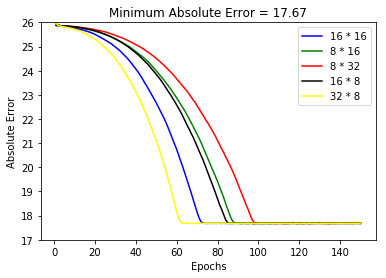

In [73]:
from matplotlib import pyplot as plt 

plt.clf()   # clear figure
val_acc_values0 = history_dict0_1['mean_absolute_error']
val_acc_values1 = history_dict0_2['mean_absolute_error']
val_acc_values2 = history_dict0_3['mean_absolute_error']
val_acc_values3 = history_dict0_4['mean_absolute_error']
val_acc_values4 = history_dict0_5['mean_absolute_error']

plt.plot(range(1,nepochs+1), val_acc_values0, 'b', label='16 * 16',color="blue")
plt.plot(range(1,nepochs+1), val_acc_values1, 'b', label='8 * 16',color="green")
plt.plot(range(1,nepochs+1), val_acc_values2, 'b', label='8 * 32',color="red")
plt.plot(range(1,nepochs+1), val_acc_values3, 'b', label='16 * 8',color="black")
plt.plot(range(1,nepochs+1), val_acc_values4, 'b', label='32 * 8',color="yellow")


plt.ylim((17,26))
plt.title('Minimum Absolute Error = '+ str(round(min(val_acc_values0+val_acc_values1+val_acc_values2+val_acc_values3+val_acc_values4),2)))
plt.xlabel('Epochs')
plt.ylabel('Absolute Error')
plt.legend()

plt.show()

All combinations that show convergence pattern converges to same level of error. Hidden layer of 32 x 8 neurons were chosen for further evaluation.

## L1 Regularization

In [77]:
converge = False
while not converge:
    # Creating Models
    lam = 0.0001

    model = models.Sequential()
    model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1(lam), input_shape = (len(ALL_STATES),) ))
    model.add(layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l1(lam)))
    model.add(layers.Dense(1, activation='relu'))
    model.summary()

    # Training
    nepochs = 150
    model.compile(optimizer='rmsprop',
                  loss='mae',
                  metrics=['mae'])
    history = model.fit(x_train, y_train,
              epochs=nepochs,
              batch_size=32,
              validation_data=(x_test, y_test))

    history_dict1 = history.history
    if history_dict1['mean_absolute_error'][-1] < 20:
        converge = True

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_148 (Dense)            (None, 32)                256       
_________________________________________________________________
dense_149 (Dense)            (None, 8)                 264       
_________________________________________________________________
dense_150 (Dense)            (None, 1)                 9         
Total params: 529
Trainable params: 529
Non-trainable params: 0
_________________________________________________________________
Train on 750 samples, validate on 750 samples
Epoch 1/150
750/750 [==============================] - 3s 4ms/step - loss: 25.8801 - mean_absolute_error: 25.8719 - val_loss: 29.3033 - val_mean_absolute_error: 29.2955
Epoch 2/150
750/750 [==============================] - 0s 116us/step - loss: 25.8710 - mean_absolute_error: 25.8635 - val_loss: 29.2956 - val_mean_absolute_error: 29.2884
Epoch 3/150
750/750 [=

750/750 [==============================] - 0s 273us/step - loss: 24.8831 - mean_absolute_error: 24.8765 - val_loss: 28.3314 - val_mean_absolute_error: 28.3248
Epoch 45/150
750/750 [==============================] - 0s 252us/step - loss: 24.8331 - mean_absolute_error: 24.8264 - val_loss: 28.2828 - val_mean_absolute_error: 28.2761
Epoch 46/150
750/750 [==============================] - 0s 279us/step - loss: 24.7809 - mean_absolute_error: 24.7741 - val_loss: 28.2318 - val_mean_absolute_error: 28.2250
Epoch 47/150
750/750 [==============================] - 0s 248us/step - loss: 24.7260 - mean_absolute_error: 24.7191 - val_loss: 28.1780 - val_mean_absolute_error: 28.1711
Epoch 48/150
750/750 [==============================] - 0s 282us/step - loss: 24.6704 - mean_absolute_error: 24.6634 - val_loss: 28.1249 - val_mean_absolute_error: 28.1179
Epoch 49/150
750/750 [==============================] - 0s 271us/step - loss: 24.6129 - mean_absolute_error: 24.6058 - val_loss: 28.0646 - val_mean_absol

Epoch 92/150
750/750 [==============================] - 0s 113us/step - loss: 19.8953 - mean_absolute_error: 19.8829 - val_loss: 23.5294 - val_mean_absolute_error: 23.5169
Epoch 93/150
750/750 [==============================] - 0s 149us/step - loss: 19.7322 - mean_absolute_error: 19.7196 - val_loss: 23.3541 - val_mean_absolute_error: 23.3415
Epoch 94/150
750/750 [==============================] - 0s 149us/step - loss: 19.5397 - mean_absolute_error: 19.5270 - val_loss: 23.1507 - val_mean_absolute_error: 23.1379
Epoch 95/150
750/750 [==============================] - 0s 108us/step - loss: 19.3260 - mean_absolute_error: 19.3131 - val_loss: 22.9630 - val_mean_absolute_error: 22.9500
Epoch 96/150
750/750 [==============================] - 0s 285us/step - loss: 19.1216 - mean_absolute_error: 19.1085 - val_loss: 22.7515 - val_mean_absolute_error: 22.7384
Epoch 97/150
750/750 [==============================] - 0s 194us/step - loss: 18.9145 - mean_absolute_error: 18.9013 - val_loss: 22.5738 - v

750/750 [==============================] - 0s 142us/step - loss: 17.6966 - mean_absolute_error: 17.6833 - val_loss: 21.7532 - val_mean_absolute_error: 21.7399
Epoch 140/150
750/750 [==============================] - 0s 119us/step - loss: 17.6986 - mean_absolute_error: 17.6853 - val_loss: 21.7410 - val_mean_absolute_error: 21.7278
Epoch 141/150
750/750 [==============================] - 0s 146us/step - loss: 17.6914 - mean_absolute_error: 17.6782 - val_loss: 21.7341 - val_mean_absolute_error: 21.7209
Epoch 142/150
750/750 [==============================] - 0s 144us/step - loss: 17.6969 - mean_absolute_error: 17.6837 - val_loss: 21.7436 - val_mean_absolute_error: 21.7304
Epoch 143/150
750/750 [==============================] - 0s 219us/step - loss: 17.6914 - mean_absolute_error: 17.6782 - val_loss: 21.7483 - val_mean_absolute_error: 21.7350
Epoch 144/150
750/750 [==============================] - 0s 226us/step - loss: 17.6905 - mean_absolute_error: 17.6772 - val_loss: 21.7405 - val_mean_

## L2 Regularization

In [78]:
converge = False
while not converge:
    # Creating Models
    lam = 0.0001

    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(lam), input_shape = (len(ALL_STATES),) ))
    model.add(layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(lam)))
    model.add(layers.Dense(1, activation='relu'))
    model.summary()

    # Training
    nepochs = 150
    model.compile(optimizer='rmsprop',
                  loss='mae',
                  metrics=['mae'])
    history = model.fit(x_train, y_train,
              epochs=nepochs,
              batch_size=32,
              validation_data=(x_test, y_test))

    history_dict2 = history.history
    if history_dict2['mean_absolute_error'][-1] < 20:
        converge = True

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_151 (Dense)            (None, 16)                128       
_________________________________________________________________
dense_152 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_153 (Dense)            (None, 1)                 9         
Total params: 273
Trainable params: 273
Non-trainable params: 0
_________________________________________________________________
Train on 750 samples, validate on 750 samples
Epoch 1/150
750/750 [==============================] - 3s 4ms/step - loss: 25.8781 - mean_absolute_error: 25.8763 - val_loss: 29.3034 - val_mean_absolute_error: 29.3017
Epoch 2/150
750/750 [==============================] - 0s 126us/step - loss: 25.8739 - mean_absolute_error: 25.8722 - val_loss: 29.3007 - val_mean_absolute_error: 29.2991
Epoch 3/150
750/750 [=

750/750 [==============================] - 0s 205us/step - loss: 24.8434 - mean_absolute_error: 24.8401 - val_loss: 28.2841 - val_mean_absolute_error: 28.2807
Epoch 45/150
750/750 [==============================] - 0s 157us/step - loss: 24.7762 - mean_absolute_error: 24.7727 - val_loss: 28.2223 - val_mean_absolute_error: 28.2188
Epoch 46/150
750/750 [==============================] - 0s 143us/step - loss: 24.7087 - mean_absolute_error: 24.7052 - val_loss: 28.1535 - val_mean_absolute_error: 28.1499
Epoch 47/150
750/750 [==============================] - 0s 158us/step - loss: 24.6376 - mean_absolute_error: 24.6340 - val_loss: 28.0859 - val_mean_absolute_error: 28.0822
Epoch 48/150
750/750 [==============================] - 0s 142us/step - loss: 24.5692 - mean_absolute_error: 24.5654 - val_loss: 28.0231 - val_mean_absolute_error: 28.0193
Epoch 49/150
750/750 [==============================] - 0s 147us/step - loss: 24.4993 - mean_absolute_error: 24.4954 - val_loss: 27.9506 - val_mean_absol

Epoch 92/150
750/750 [==============================] - 0s 154us/step - loss: 17.7827 - mean_absolute_error: 17.7717 - val_loss: 21.7176 - val_mean_absolute_error: 21.7066
Epoch 93/150
750/750 [==============================] - 0s 187us/step - loss: 17.7207 - mean_absolute_error: 17.7096 - val_loss: 21.7293 - val_mean_absolute_error: 21.7182
Epoch 94/150
750/750 [==============================] - 0s 247us/step - loss: 17.6935 - mean_absolute_error: 17.6823 - val_loss: 21.7336 - val_mean_absolute_error: 21.7224
Epoch 95/150
750/750 [==============================] - 0s 274us/step - loss: 17.6893 - mean_absolute_error: 17.6781 - val_loss: 21.7356 - val_mean_absolute_error: 21.7244
Epoch 96/150
750/750 [==============================] - 0s 254us/step - loss: 17.6850 - mean_absolute_error: 17.6738 - val_loss: 21.7439 - val_mean_absolute_error: 21.7326
Epoch 97/150
750/750 [==============================] - 0s 267us/step - loss: 17.6889 - mean_absolute_error: 17.6777 - val_loss: 21.7479 - v

750/750 [==============================] - 0s 252us/step - loss: 17.6938 - mean_absolute_error: 17.6824 - val_loss: 21.7323 - val_mean_absolute_error: 21.7209
Epoch 140/150
750/750 [==============================] - 0s 266us/step - loss: 17.6905 - mean_absolute_error: 17.6791 - val_loss: 21.7488 - val_mean_absolute_error: 21.7374
Epoch 141/150
750/750 [==============================] - 0s 275us/step - loss: 17.6853 - mean_absolute_error: 17.6738 - val_loss: 21.7506 - val_mean_absolute_error: 21.7391
Epoch 142/150
750/750 [==============================] - 0s 270us/step - loss: 17.6966 - mean_absolute_error: 17.6852 - val_loss: 21.7316 - val_mean_absolute_error: 21.7202
Epoch 143/150
750/750 [==============================] - 0s 273us/step - loss: 17.6940 - mean_absolute_error: 17.6825 - val_loss: 21.7280 - val_mean_absolute_error: 21.7166
Epoch 144/150
750/750 [==============================] - 0s 263us/step - loss: 17.6957 - mean_absolute_error: 17.6842 - val_loss: 21.7349 - val_mean_

## Choose Regularization

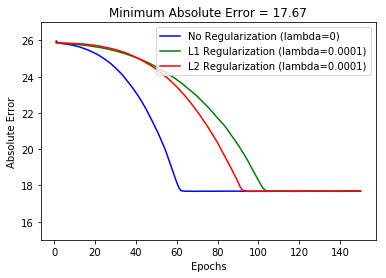

In [79]:
plt.clf()   # clear figure
val_acc_values0 = history_dict0_5['mean_absolute_error']
val_acc_values1 = history_dict1['mean_absolute_error']
val_acc_values2 = history_dict2['mean_absolute_error']

plt.plot(range(1,nepochs+1), val_acc_values0, 'b', label='No Regularization (lambda=0)',color="blue")
plt.plot(range(1,nepochs+1), val_acc_values1, 'b', label='L1 Regularization (lambda=0.0001)',color="green")
plt.plot(range(1,nepochs+1), val_acc_values2, 'b', label='L2 Regularization (lambda=0.0001)',color="red")


plt.ylim((15,27))
plt.title('Minimum Absolute Error = '+ str(round(min(val_acc_values0+val_acc_values1+val_acc_values2),2)))
plt.xlabel('Epochs')
plt.ylabel('Absolute Error')
plt.legend()

plt.show()

Again, given the NN converges, different regularization methods appears to have no effect on the error the NN converges to. The convergence is faster when no regularization method is used.

## Dropouts

In [85]:
converge = False
while not converge:
    # Creating Models
    dropout_rate = 0.2
    lam = 0.0001

    model = models.Sequential()
    model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(lam), input_shape = (len(ALL_STATES),) ))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(8, kernel_regularizer=regularizers.l2(lam), activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation='relu'))
    model.summary()

    # Training
    nepochs = 150
    model.compile(optimizer='rmsprop',
                  loss='mae',
                  metrics=['mae'])
    history = model.fit(x_train, y_train,
              epochs=nepochs,
              batch_size=32,
              validation_data=(x_test, y_test))

    history_dict_d3 = history.history
    if history_dict_d3['mean_absolute_error'][-1] < 20:
        converge = True

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_166 (Dense)            (None, 32)                256       
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_167 (Dense)            (None, 8)                 264       
_________________________________________________________________
dropout_10 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_168 (Dense)            (None, 1)                 9         
Total params: 529
Trainable params: 529
Non-trainable params: 0
_________________________________________________________________
Train on 750 samples, validate on 750 samples
Epoch 1/150
750/750 [==============================] - 3s 5ms/step - loss: 25.8826 - mean_absolute

Epoch 43/150
750/750 [==============================] - 0s 283us/step - loss: 24.5971 - mean_absolute_error: 24.5928 - val_loss: 27.9510 - val_mean_absolute_error: 27.9466
Epoch 44/150
750/750 [==============================] - 0s 281us/step - loss: 24.3406 - mean_absolute_error: 24.3361 - val_loss: 27.8545 - val_mean_absolute_error: 27.8500
Epoch 45/150
750/750 [==============================] - 0s 296us/step - loss: 24.4851 - mean_absolute_error: 24.4805 - val_loss: 27.7705 - val_mean_absolute_error: 27.7658
Epoch 46/150
750/750 [==============================] - 0s 292us/step - loss: 24.2457 - mean_absolute_error: 24.2409 - val_loss: 27.6820 - val_mean_absolute_error: 27.6771
Epoch 47/150
750/750 [==============================] - 0s 295us/step - loss: 24.1444 - mean_absolute_error: 24.1394 - val_loss: 27.5806 - val_mean_absolute_error: 27.5755
Epoch 48/150
750/750 [==============================] - 0s 294us/step - loss: 24.1263 - mean_absolute_error: 24.1212 - val_loss: 27.4792 - v

750/750 [==============================] - 0s 177us/step - loss: 19.4341 - mean_absolute_error: 19.4215 - val_loss: 22.7988 - val_mean_absolute_error: 22.7862
Epoch 91/150
750/750 [==============================] - 0s 178us/step - loss: 19.5170 - mean_absolute_error: 19.5043 - val_loss: 22.8419 - val_mean_absolute_error: 22.8293
Epoch 92/150
750/750 [==============================] - 0s 182us/step - loss: 19.6167 - mean_absolute_error: 19.6041 - val_loss: 22.7932 - val_mean_absolute_error: 22.7805
Epoch 93/150
750/750 [==============================] - 0s 174us/step - loss: 18.9928 - mean_absolute_error: 18.9802 - val_loss: 22.8450 - val_mean_absolute_error: 22.8325
Epoch 94/150
750/750 [==============================] - 0s 172us/step - loss: 20.1194 - mean_absolute_error: 20.1068 - val_loss: 22.7323 - val_mean_absolute_error: 22.7197
Epoch 95/150
750/750 [==============================] - 0s 211us/step - loss: 19.9229 - mean_absolute_error: 19.9103 - val_loss: 22.7606 - val_mean_absol

750/750 [==============================] - 0s 303us/step - loss: 19.6765 - mean_absolute_error: 19.6642 - val_loss: 22.9719 - val_mean_absolute_error: 22.9596
Epoch 138/150
750/750 [==============================] - 0s 295us/step - loss: 19.6545 - mean_absolute_error: 19.6422 - val_loss: 22.9038 - val_mean_absolute_error: 22.8914
Epoch 139/150
750/750 [==============================] - 0s 315us/step - loss: 19.7521 - mean_absolute_error: 19.7396 - val_loss: 22.8070 - val_mean_absolute_error: 22.7945
Epoch 140/150
750/750 [==============================] - 0s 301us/step - loss: 19.9511 - mean_absolute_error: 19.9386 - val_loss: 22.8290 - val_mean_absolute_error: 22.8165
Epoch 141/150
750/750 [==============================] - 0s 306us/step - loss: 19.0681 - mean_absolute_error: 19.0556 - val_loss: 22.9473 - val_mean_absolute_error: 22.9349
Epoch 142/150
750/750 [==============================] - 0s 319us/step - loss: 19.5481 - mean_absolute_error: 19.5357 - val_loss: 23.0140 - val_mean_

In [82]:
# Creating Models
dropout_rate = 0.3
lam = 0.0001

model = models.Sequential()
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(lam), input_shape = (len(ALL_STATES),) ))
model.add(layers.Dropout(dropout_rate))
model.add(layers.Dense(8, kernel_regularizer=regularizers.l2(lam), activation='relu'))
model.add(layers.Dropout(dropout_rate))
model.add(layers.Dense(1, activation='relu'))
model.summary()

# Training
nepochs = 150
model.compile(optimizer='rmsprop',
              loss='mae',
              metrics=['mae'])
history = model.fit(x_train, y_train,
          epochs=nepochs,
          batch_size=32,
          validation_data=(x_test, y_test))

history_dict_d5 = history.history

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_160 (Dense)            (None, 32)                256       
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_161 (Dense)            (None, 8)                 264       
_________________________________________________________________
dropout_6 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_162 (Dense)            (None, 1)                 9         
Total params: 529
Trainable params: 529
Non-trainable params: 0
_________________________________________________________________
Train on 750 samples, validate on 750 samples
Epoch 1/150
750/750 [==============================] - 3s 4ms/step - loss: 25.9708 - mean_absolute

Epoch 43/150
750/750 [==============================] - 0s 271us/step - loss: 23.7953 - mean_absolute_error: 23.7905 - val_loss: 27.1634 - val_mean_absolute_error: 27.1585
Epoch 44/150
750/750 [==============================] - 0s 297us/step - loss: 23.5931 - mean_absolute_error: 23.5880 - val_loss: 27.0163 - val_mean_absolute_error: 27.0111
Epoch 45/150
750/750 [==============================] - 0s 269us/step - loss: 23.5399 - mean_absolute_error: 23.5346 - val_loss: 26.8707 - val_mean_absolute_error: 26.8653
Epoch 46/150
750/750 [==============================] - 0s 276us/step - loss: 22.9781 - mean_absolute_error: 22.9726 - val_loss: 26.7069 - val_mean_absolute_error: 26.7014
Epoch 47/150
750/750 [==============================] - 0s 283us/step - loss: 22.8229 - mean_absolute_error: 22.8172 - val_loss: 26.5093 - val_mean_absolute_error: 26.5035
Epoch 48/150
750/750 [==============================] - 0s 302us/step - loss: 22.8044 - mean_absolute_error: 22.7984 - val_loss: 26.3412 - v

750/750 [==============================] - 0s 266us/step - loss: 19.9925 - mean_absolute_error: 19.9817 - val_loss: 22.2913 - val_mean_absolute_error: 22.2805
Epoch 91/150
750/750 [==============================] - 0s 270us/step - loss: 19.7311 - mean_absolute_error: 19.7203 - val_loss: 22.3533 - val_mean_absolute_error: 22.3426
Epoch 92/150
750/750 [==============================] - 0s 293us/step - loss: 19.3292 - mean_absolute_error: 19.3185 - val_loss: 22.4963 - val_mean_absolute_error: 22.4856
Epoch 93/150
750/750 [==============================] - 0s 296us/step - loss: 19.3146 - mean_absolute_error: 19.3039 - val_loss: 22.4865 - val_mean_absolute_error: 22.4758
Epoch 94/150
750/750 [==============================] - 0s 274us/step - loss: 19.7389 - mean_absolute_error: 19.7282 - val_loss: 22.4840 - val_mean_absolute_error: 22.4734
Epoch 95/150
750/750 [==============================] - 0s 284us/step - loss: 19.1793 - mean_absolute_error: 19.1686 - val_loss: 22.3478 - val_mean_absol

750/750 [==============================] - 0s 260us/step - loss: 19.8120 - mean_absolute_error: 19.8017 - val_loss: 22.3465 - val_mean_absolute_error: 22.3362
Epoch 138/150
750/750 [==============================] - 0s 250us/step - loss: 19.4996 - mean_absolute_error: 19.4893 - val_loss: 22.3513 - val_mean_absolute_error: 22.3410
Epoch 139/150
750/750 [==============================] - 0s 285us/step - loss: 19.6160 - mean_absolute_error: 19.6057 - val_loss: 22.3856 - val_mean_absolute_error: 22.3754
Epoch 140/150
750/750 [==============================] - 0s 288us/step - loss: 19.8245 - mean_absolute_error: 19.8143 - val_loss: 22.3485 - val_mean_absolute_error: 22.3382
Epoch 141/150
750/750 [==============================] - 0s 289us/step - loss: 19.7029 - mean_absolute_error: 19.6925 - val_loss: 22.2640 - val_mean_absolute_error: 22.2536
Epoch 142/150
750/750 [==============================] - 0s 296us/step - loss: 19.3131 - mean_absolute_error: 19.3027 - val_loss: 22.2425 - val_mean_

In [83]:
# Creating Models
dropout_rate = 0.4
lam = 0.0001

model = models.Sequential()
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(lam), input_shape = (len(ALL_STATES),) ))
model.add(layers.Dropout(dropout_rate))
model.add(layers.Dense(8, kernel_regularizer=regularizers.l2(lam), activation='relu'))
model.add(layers.Dropout(dropout_rate))
model.add(layers.Dense(1, activation='relu'))
model.summary()

# Training
nepochs = 150
model.compile(optimizer='rmsprop',
              loss='mae',
              metrics=['mae'])
history = model.fit(x_train, y_train,
          epochs=nepochs,
          batch_size=32,
          validation_data=(x_test, y_test))

history_dict_d7 = history.history

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_163 (Dense)            (None, 32)                256       
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_164 (Dense)            (None, 8)                 264       
_________________________________________________________________
dropout_8 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_165 (Dense)            (None, 1)                 9         
Total params: 529
Trainable params: 529
Non-trainable params: 0
_________________________________________________________________
Train on 750 samples, validate on 750 samples
Epoch 1/150
750/750 [==============================] - 3s 4ms/step - loss: 25.9264 - mean_absolute

Epoch 43/150
750/750 [==============================] - 0s 301us/step - loss: 24.6519 - mean_absolute_error: 24.6485 - val_loss: 28.1370 - val_mean_absolute_error: 28.1335
Epoch 44/150
750/750 [==============================] - 0s 311us/step - loss: 24.4773 - mean_absolute_error: 24.4738 - val_loss: 28.0403 - val_mean_absolute_error: 28.0367
Epoch 45/150
750/750 [==============================] - 0s 307us/step - loss: 24.4844 - mean_absolute_error: 24.4807 - val_loss: 27.9535 - val_mean_absolute_error: 27.9497
Epoch 46/150
750/750 [==============================] - 0s 313us/step - loss: 24.5898 - mean_absolute_error: 24.5860 - val_loss: 27.8633 - val_mean_absolute_error: 27.8594
Epoch 47/150
750/750 [==============================] - 0s 319us/step - loss: 24.3183 - mean_absolute_error: 24.3144 - val_loss: 27.7621 - val_mean_absolute_error: 27.7580
Epoch 48/150
750/750 [==============================] - 0s 310us/step - loss: 24.2088 - mean_absolute_error: 24.2047 - val_loss: 27.6665 - v

750/750 [==============================] - 0s 276us/step - loss: 20.3112 - mean_absolute_error: 20.3011 - val_loss: 22.8421 - val_mean_absolute_error: 22.8320
Epoch 91/150
750/750 [==============================] - 0s 279us/step - loss: 20.1910 - mean_absolute_error: 20.1809 - val_loss: 22.9519 - val_mean_absolute_error: 22.9418
Epoch 92/150
750/750 [==============================] - 0s 285us/step - loss: 20.9509 - mean_absolute_error: 20.9408 - val_loss: 22.8729 - val_mean_absolute_error: 22.8627
Epoch 93/150
750/750 [==============================] - 0s 291us/step - loss: 20.5190 - mean_absolute_error: 20.5090 - val_loss: 23.0059 - val_mean_absolute_error: 22.9958
Epoch 94/150
750/750 [==============================] - 0s 285us/step - loss: 20.1600 - mean_absolute_error: 20.1499 - val_loss: 22.9912 - val_mean_absolute_error: 22.9811
Epoch 95/150
750/750 [==============================] - 0s 298us/step - loss: 21.1382 - mean_absolute_error: 21.1281 - val_loss: 22.9337 - val_mean_absol

750/750 [==============================] - 0s 191us/step - loss: 20.1695 - mean_absolute_error: 20.1598 - val_loss: 22.9862 - val_mean_absolute_error: 22.9765
Epoch 138/150
750/750 [==============================] - 0s 201us/step - loss: 20.7272 - mean_absolute_error: 20.7176 - val_loss: 22.9626 - val_mean_absolute_error: 22.9529
Epoch 139/150
750/750 [==============================] - 0s 205us/step - loss: 20.6536 - mean_absolute_error: 20.6439 - val_loss: 22.9303 - val_mean_absolute_error: 22.9206
Epoch 140/150
750/750 [==============================] - 0s 219us/step - loss: 20.7446 - mean_absolute_error: 20.7350 - val_loss: 22.9137 - val_mean_absolute_error: 22.9040
Epoch 141/150
750/750 [==============================] - 0s 211us/step - loss: 20.6203 - mean_absolute_error: 20.6105 - val_loss: 22.8928 - val_mean_absolute_error: 22.8831
Epoch 142/150
750/750 [==============================] - 0s 226us/step - loss: 20.6197 - mean_absolute_error: 20.6100 - val_loss: 22.7846 - val_mean_

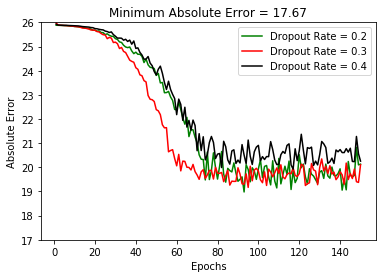

In [89]:
plt.clf()   # clear figure
val_acc_values0 = history_dict0_5['mean_absolute_error']
val_acc_values1 = history_dict_d3['mean_absolute_error']
val_acc_values2 = history_dict_d5['mean_absolute_error']
val_acc_values3 = history_dict_d7['mean_absolute_error']

#plt.plot(range(1,nepochs+1), val_acc_values0, 'b', label='L1 Regularization (lambda=0.0001), No Dropouts',color="blue")
plt.plot(range(1,nepochs+1), val_acc_values1, 'b', label='Dropout Rate = 0.2',color="green")
plt.plot(range(1,nepochs+1), val_acc_values2, 'b', label='Dropout Rate = 0.3',color="red")
plt.plot(range(1,nepochs+1), val_acc_values3, 'b', label='Dropout Rate = 0.4',color="black")


plt.ylim((17, 26))
plt.title('Minimum Absolute Error = '+ str(round(min(val_acc_values0+val_acc_values1+val_acc_values2+val_acc_values3),2)))
plt.xlabel('Epochs')
plt.ylabel('Absolute Error')
plt.legend()

plt.show()

Dropout does not appear to cause significant improvement in the optimal performance (16.58) of the NN on training set. No dropout would be used for final model

## Training Error vs Validation Error

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_175 (Dense)            (None, 32)                256       
_________________________________________________________________
dense_176 (Dense)            (None, 8)                 264       
_________________________________________________________________
dense_177 (Dense)            (None, 1)                 9         
Total params: 529
Trainable params: 529
Non-trainable params: 0
_________________________________________________________________
Train on 750 samples, validate on 1500 samples
Epoch 1/150
750/750 [==============================] - 3s 4ms/step - loss: 25.9457 - mean_absolute_error: 25.9457 - val_loss: 27.3598 - val_mean_absolute_error: 27.3598
Epoch 2/150
750/750 [==============================] - 0s 67us/step - loss: 25.8788 - mean_absolute_error: 25.8788 - val_loss: 27.3405 - val_mean_absolute_error: 27.3405
Epoch 3/150
750/750 [=

750/750 [==============================] - 0s 205us/step - loss: 25.5709 - mean_absolute_error: 25.5709 - val_loss: 27.0414 - val_mean_absolute_error: 27.0414
Epoch 45/150
750/750 [==============================] - 0s 193us/step - loss: 25.5574 - mean_absolute_error: 25.5574 - val_loss: 27.0276 - val_mean_absolute_error: 27.0276
Epoch 46/150
750/750 [==============================] - 0s 202us/step - loss: 25.5434 - mean_absolute_error: 25.5434 - val_loss: 27.0147 - val_mean_absolute_error: 27.0147
Epoch 47/150
750/750 [==============================] - 0s 241us/step - loss: 25.5299 - mean_absolute_error: 25.5299 - val_loss: 27.0006 - val_mean_absolute_error: 27.0006
Epoch 48/150
750/750 [==============================] - 0s 143us/step - loss: 25.5150 - mean_absolute_error: 25.5150 - val_loss: 26.9861 - val_mean_absolute_error: 26.9861
Epoch 49/150
750/750 [==============================] - 0s 114us/step - loss: 25.4996 - mean_absolute_error: 25.4996 - val_loss: 26.9716 - val_mean_absol

Epoch 92/150
750/750 [==============================] - 0s 203us/step - loss: 24.5106 - mean_absolute_error: 24.5106 - val_loss: 26.0112 - val_mean_absolute_error: 26.0112
Epoch 93/150
750/750 [==============================] - 0s 188us/step - loss: 24.4815 - mean_absolute_error: 24.4815 - val_loss: 25.9779 - val_mean_absolute_error: 25.9779
Epoch 94/150
750/750 [==============================] - 0s 198us/step - loss: 24.4470 - mean_absolute_error: 24.4470 - val_loss: 25.9450 - val_mean_absolute_error: 25.9450
Epoch 95/150
750/750 [==============================] - 0s 176us/step - loss: 24.4127 - mean_absolute_error: 24.4127 - val_loss: 25.9081 - val_mean_absolute_error: 25.9081
Epoch 96/150
750/750 [==============================] - 0s 188us/step - loss: 24.3753 - mean_absolute_error: 24.3753 - val_loss: 25.8756 - val_mean_absolute_error: 25.8756
Epoch 97/150
750/750 [==============================] - 0s 203us/step - loss: 24.3389 - mean_absolute_error: 24.3389 - val_loss: 25.8390 - v

750/750 [==============================] - 0s 214us/step - loss: 22.2837 - mean_absolute_error: 22.2837 - val_loss: 23.8441 - val_mean_absolute_error: 23.8441
Epoch 140/150
750/750 [==============================] - 0s 190us/step - loss: 22.2214 - mean_absolute_error: 22.2214 - val_loss: 23.7805 - val_mean_absolute_error: 23.7805
Epoch 141/150
750/750 [==============================] - 0s 201us/step - loss: 22.1574 - mean_absolute_error: 22.1574 - val_loss: 23.7192 - val_mean_absolute_error: 23.7192
Epoch 142/150
750/750 [==============================] - 0s 172us/step - loss: 22.0955 - mean_absolute_error: 22.0955 - val_loss: 23.6547 - val_mean_absolute_error: 23.6547
Epoch 143/150
750/750 [==============================] - 0s 198us/step - loss: 22.0283 - mean_absolute_error: 22.0283 - val_loss: 23.5919 - val_mean_absolute_error: 23.5919
Epoch 144/150
750/750 [==============================] - 0s 207us/step - loss: 21.9588 - mean_absolute_error: 21.9588 - val_loss: 23.5216 - val_mean_

750/750 [==============================] - 0s 192us/step - loss: 25.5531 - mean_absolute_error: 25.5531 - val_loss: 27.0206 - val_mean_absolute_error: 27.0206
Epoch 33/150
750/750 [==============================] - 0s 188us/step - loss: 25.5350 - mean_absolute_error: 25.5350 - val_loss: 27.0053 - val_mean_absolute_error: 27.0053
Epoch 34/150
750/750 [==============================] - 0s 213us/step - loss: 25.5168 - mean_absolute_error: 25.5168 - val_loss: 26.9857 - val_mean_absolute_error: 26.9857
Epoch 35/150
750/750 [==============================] - 0s 184us/step - loss: 25.4964 - mean_absolute_error: 25.4964 - val_loss: 26.9643 - val_mean_absolute_error: 26.9643
Epoch 36/150
750/750 [==============================] - 0s 200us/step - loss: 25.4749 - mean_absolute_error: 25.4749 - val_loss: 26.9449 - val_mean_absolute_error: 26.9449
Epoch 37/150
750/750 [==============================] - 0s 214us/step - loss: 25.4521 - mean_absolute_error: 25.4521 - val_loss: 26.9206 - val_mean_absol

Epoch 80/150
750/750 [==============================] - 0s 198us/step - loss: 23.4513 - mean_absolute_error: 23.4513 - val_loss: 24.9660 - val_mean_absolute_error: 24.9660
Epoch 81/150
750/750 [==============================] - 0s 212us/step - loss: 23.3763 - mean_absolute_error: 23.3763 - val_loss: 24.8833 - val_mean_absolute_error: 24.8833
Epoch 82/150
750/750 [==============================] - 0s 227us/step - loss: 23.2967 - mean_absolute_error: 23.2967 - val_loss: 24.8102 - val_mean_absolute_error: 24.8102
Epoch 83/150
750/750 [==============================] - 0s 232us/step - loss: 23.2146 - mean_absolute_error: 23.2146 - val_loss: 24.7290 - val_mean_absolute_error: 24.7290
Epoch 84/150
750/750 [==============================] - 0s 246us/step - loss: 23.1376 - mean_absolute_error: 23.1376 - val_loss: 24.6517 - val_mean_absolute_error: 24.6517
Epoch 85/150
750/750 [==============================] - 0s 240us/step - loss: 23.0484 - mean_absolute_error: 23.0484 - val_loss: 24.5801 - v

750/750 [==============================] - 0s 94us/step - loss: 17.9036 - mean_absolute_error: 17.9036 - val_loss: 19.6408 - val_mean_absolute_error: 19.6408
Epoch 128/150
750/750 [==============================] - 0s 111us/step - loss: 17.7870 - mean_absolute_error: 17.7870 - val_loss: 19.5990 - val_mean_absolute_error: 19.5990
Epoch 129/150
750/750 [==============================] - 0s 99us/step - loss: 17.7196 - mean_absolute_error: 17.7196 - val_loss: 19.5805 - val_mean_absolute_error: 19.5805
Epoch 130/150
750/750 [==============================] - 0s 120us/step - loss: 17.6959 - mean_absolute_error: 17.6959 - val_loss: 19.5749 - val_mean_absolute_error: 19.5749
Epoch 131/150
750/750 [==============================] - 0s 119us/step - loss: 17.6809 - mean_absolute_error: 17.6809 - val_loss: 19.5768 - val_mean_absolute_error: 19.5768
Epoch 132/150
750/750 [==============================] - 0s 110us/step - loss: 17.6807 - mean_absolute_error: 17.6807 - val_loss: 19.5794 - val_mean_ab

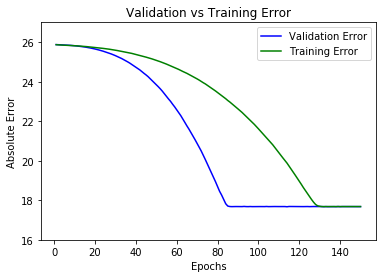

In [95]:
converge = False
while not converge:
    # Reconstruct Selected Model
    model = models.Sequential()
    model.add(layers.Dense(32, activation='relu', input_shape = (len(ALL_STATES),) ))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(1, activation='relu'))
    model.summary()

    # Validating
    nepochs = 150
    model.compile(optimizer='rmsprop',
                  loss='mae',
                  metrics=['mae'])
    history = model.fit(x_train, y_train,
              epochs=nepochs,
              batch_size=32,
              validation_data=(x_input, y_input))

    history_dict_final = history.history
    if history_dict_final['mean_absolute_error'][-1] < 20:
        converge = True

plt.clf()   # clear figure
val_acc_values0 = history_dict0_4['mean_absolute_error']
val_acc_values1 = history_dict_final['mean_absolute_error']

plt.plot(range(1,nepochs+1), val_acc_values0, 'b', label='Validation Error',color="blue")
plt.plot(range(1,nepochs+1), val_acc_values1, 'b', label='Training Error',color="green")


plt.ylim((16, 27))
plt.title('Validation vs Training Error')
plt.xlabel('Epochs')
plt.ylabel('Absolute Error')
plt.legend()

plt.show()

## Final NN State Estimates

In [91]:
x_input = np.asarray([np.asarray([int(s == k) for k in ALL_STATES]) for s in ALL_STATES])
v = model.predict(x_input)

print(v)
print("States:", ["ABC", "AC", "C"])
print("v_pi:", [v[0][0], v[2][0], v[-1][0]])

[[  0.     ]
 [  0.     ]
 [120.42113]
 [  0.     ]
 [  0.     ]
 [  0.     ]
 [  0.     ]]
States: ['ABC', 'AC', 'C']
v_pi: [0.0, 120.42113, 0.0]
